# Quantum Control: X, Y, X90, Y90 Gate Optimization and Benchmarking

This notebook mirrors the gate-optimization and randomized benchmarking flow used for Hadamard/S/T gates, but targets four additional single-qubit gates:

- X (pi rotation about X)
- Y (pi rotation about Y)
- X90 (pi/2 rotation about X)
- Y90 (pi/2 rotation about Y)

Structure:
1. Optimize each gate using the IQ PTM-based cost in `src/optimization.py`.
2. Run a simplified randomized benchmarking-style sequence fidelity scan for each optimized pulse using helpers in `src/benchmarking.py`.

In [1]:
# Import the modular quantum control framework
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import src.benchmarking as bm
from src import run_sequence_benchmark, benchmarking_summary
from pprint import pprint
import pandas as pd
from qutip import Bloch, ptrace, basis, sigmax, sigmay, sigmaz, expect
import numpy as np
import time

# Import our modular framework components
from src import (
    # Configuration and constants
    time_array, DEFAULT_FOURIER_MODES, QUBIT_FREQUENCY, CAVITY_FREQUENCY, COUPLING_STRENGTH,
    CAVITY_DISSIPATION, QUBIT_DISSIPATION, QUBIT_DEPHASING,
    
    # Core quantum mechanics
    get_initial_state, create_operators, construct_system_hamiltonian,
    simulate_controlled_evolution,
    
    # Visualization
    QuantumControlPlotter,
)

from src.operators import get_collapse_operators
from src.dynamics import simulate_controlled_evolution, compute_fourier_control_field, simulate_controlled_evolution_iq, compute_iq_control_fields
from src.utils import build_iq_vector, split_iq_vector
import src.optimization as _opt

# Initialize plotter (disable LaTeX for portability here)
plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

print(f"Quantum Control Framework Initialized")
print(f"System Parameters:")
print(f"  Cavity frequency: {CAVITY_FREQUENCY/(2*np.pi):.3f} GHz")
print(f"  Qubit frequency: {QUBIT_FREQUENCY/(2*np.pi):.3f} GHz")
print(f"  Coupling strength: {COUPLING_STRENGTH/(2*np.pi):.3f} GHz")
print(f"  Evolution time: {time_array[-1]:.1f} ns")
print(f"  Fourier modes: {DEFAULT_FOURIER_MODES}")

Quantum Control Framework Initialized
System Parameters:
  Cavity frequency: 3.000 GHz
  Qubit frequency: 1.000 GHz
  Coupling strength: 0.100 GHz
  Evolution time: 10.0 ns
  Fourier modes: 32


In [2]:
# Initialize quantum system components
initial_state = get_initial_state()
operators = create_operators()
collapse_ops = get_collapse_operators(gamma_cavity=CAVITY_DISSIPATION, # ~ 0.1-5 MHz
                                      gamma_qubit=QUBIT_DISSIPATION, # ~ 1-10 KHz
                                      gamma_dephasing=QUBIT_DEPHASING # ~ 1-20 KHz
)

print(f"Initial state: Ground state |g,0⟩")
print(f"Hilbert space dimension: {initial_state.shape[0]}")
print(f"System operators created: {len(operators)} operators")

# System parameters for dynamics simulation
system_params = {
    'omega_r': CAVITY_FREQUENCY,
    'omega_t': QUBIT_FREQUENCY,
    'coupling_g': COUPLING_STRENGTH
}

Initial state: Ground state |g,0⟩
Hilbert space dimension: 10
System operators created: 18 operators


# Quantum Control: X, Y, X90, Y90 Gate Optimization and Benchmarking

This notebook mirrors the gate-optimization and randomized benchmarking flow used for Hadamard/S/T gates, but targets four additional single-qubit gates:

- X (pi rotation about X)
- Y (pi rotation about Y)
- X90 (pi/2 rotation about X)
- Y90 (pi/2 rotation about Y)

Structure:
1. Optimize each gate using the IQ PTM-based cost in `src/optimization.py`.
2. Run a simplified randomized benchmarking-style sequence fidelity scan for each optimized pulse using helpers in `src/benchmarking.py`.

In [3]:
# NOTE: Control field generation backend updated to a real cosine Fourier series.
# This fixes previously zero-valued control fields (conjugate difference cancelled) and
# removes FutureWarning from qutip Options by passing dict options.

# Helper: extract single-qubit expectation values (σx, σy, σz) from composite states list
def extract_qubit_expectations(states_list):
    ex, ey, ez = [], [], []    
    for st in states_list:
        rho_qubit = ptrace(st, 1)  # subsystem index 1 assumed to be qubit
        ex.append(expect(sigmax(), rho_qubit).real)
        ey.append(expect(sigmay(), rho_qubit).real)
        ez.append(expect(sigmaz(), rho_qubit).real)
    return np.array(ex), np.array(ey), np.array(ez)

# Ideal target single-qubit states starting from |g>
ket_g = basis(2,0)
ket_e = basis(2,1)
psi_ideal = {
    'hadamard': (ket_g + ket_e).unit(),  # (|g> + |e>)/√2
    's_gate' : ket_g,                    # S gate leaves |g> unchanged
    't_gate' : ket_g,                     # T gate leaves |g> unchanged
    'x_gate' : ket_e,                     # X gate flips |g> to |e>
    'x90_gate' : (ket_g - 1j * ket_e).unit(),  # X90 gate
    'y_gate' : ket_e,   # Y gate flips |g>  to |e>
    'y90_gate' : (ket_g + ket_e).unit(),  # Y90 gate
}

def bloch_coords(state):
    return [float(np.real(expect(sigmax(), state))),
            float(np.real(expect(sigmay(), state))),
            float(np.real(expect(sigmaz(), state)))]

ideal_bloch = { name: bloch_coords(st) for name, st in psi_ideal.items() }

missing = []
for fn_name in ['optimize_hadamard_gate','optimize_s_gate','optimize_t_gate']:
    if not hasattr(_opt, fn_name):
        missing.append(fn_name)
if missing:
    print("Missing gate optimization functions in src.optimization:", missing)
else:
    optimize_hadamard_gate = _opt.optimize_hadamard_gate  # type: ignore
    optimize_s_gate = _opt.optimize_s_gate  # type: ignore
    optimize_t_gate = _opt.optimize_t_gate  # type: ignore
    optimize_x_gate = _opt.optimize_x_gate  # type: ignore
    optimize_x90_gate = _opt.optimize_x90_gate  # type: ignore
    optimize_y_gate = _opt.optimize_y_gate  # type: ignore
    optimize_y90_gate = _opt.optimize_y90_gate  # type: ignore
    print("All gate optimization functions loaded.")

# Container accumulating per-gate results
gate_results = {}
print("Gate optimization environment ready.")

All gate optimization functions loaded.
Gate optimization environment ready.


In [ ]:
# results_load = np.load('results/x_gate/opt_x_gate_iq_modes=4_iters=1_cost=1.287e-04_20250820T142259.npz', allow_pickle=True)
# x_opt_coeffs = build_iq_vector(results_load['optimal_coefficients_I'], results_load['optimal_coefficients_Q'])
# x_opt_sim = simulate_controlled_evolution(
#     time_array,
#     fourier_coefficients=x_opt_coeffs,
#     drive_period=time_array[-1],
#     system_params=system_params,
#     initial_state=initial_state,
#     collapse_ops=collapse_ops
# )
# ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim['states'])

# control_field_x = compute_fourier_control_field(time_array, x_opt_coeffs, float(time_array[-1]))
# gate_plotter = plotter
# gate_plotter.plot_bloch_components(time_array, ex_x, ey_x, ez_x, ideal_vector=None, gate_name='X Gate')
# gate_plotter.plot_control_field_analysis(time_array, control_field_x.real, 
#                                          fourier_coefficients=x_opt_coeffs, title='X Gate Control Field Analysis')

In [5]:
# Run X gate optimization
start = time.time()
x_opt_res = optimize_x_gate(
    fourier_modes=16, max_iterations=6,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=None
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
x_opt_sim = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res['optimization_result'].x,
    drive_period=x_opt_res['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim['states'])

# Store
x_opt_cost = x_opt_res['optimization_result'].fun
x_opt_fid = 1 - x_opt_cost
gate_results['x_gate'] = {
    'result': x_opt_res,
    'traj': (ex_x, ey_x, ez_x),
    'cost': x_opt_cost,
    'fidelity': x_opt_fid,
    'time_elapsed': elapsed
}

print(f"X gate optimization complete: cost={x_opt_cost:.3e}, fidelity={x_opt_fid:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {x_opt_res['nfev']}")

Starting global optimization with 6 random initializations...
Parameter space dimension: 32
Optimization method: L-BFGS-B
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------
Iteration 1: Parameters = 32, Cost = 1.297286e-04
Iteration 2: Parameters = 32, Cost = 3.023368e-04
Iteration 3: Parameters = 32, Cost = 1.286617e-04
  → New best solution found!
Iteration 4: Parameters = 32, Cost = 1.362959e-04
Iteration 5: Parameters = 32, Cost = 1.280303e-04
  → New best solution found!
Iteration 6: Parameters = 32, Cost = 1.343131e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.280303e-04
Optimization success: True
Function evaluations: 594
X gate optimization complete: cost=1.280e-04, fidelity=0.9999, time=530.39s
Time elapsed: 530.39 seconds
Total function evaluations: 4257


In [ ]:
# np.savez('data/x_optimized1.287e-4.npz', optimized_field=x_opt_coeffs)

In [28]:
x_opt_res

{'optimization_result':   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 0.0001280303465791945
         x: [-6.321e-02  3.199e-01 ... -1.402e-01  3.180e-01]
       nit: 13
       jac: [-5.175e-05 -4.950e-05 ... -3.379e-05 -5.074e-05]
      nfev: 594
      njev: 18
  hess_inv: <32x32 LbfgsInvHessProduct with dtype=float64>,
 'target_type': 'x_gate_iq',
 'fourier_modes': 16,
 'control_period': 10.026761414789407,
 'drive_frequency': 6.283185307179586,
 'max_iterations': 6,
 'nfev': 4257,
 'coefficient_bounds': (-0.32, 0.32),
 'leakage_weight': 0.05,
 'l2_regularization': 0.0,
 'process_cost': 'ptm_iq',
 'saved_paths': {'json': 'results/x_gate/opt_x_gate_iq_modes=16_iters=6_cost=1.280e-04_20250908T024500.json',
  'npz': 'results/x_gate/opt_x_gate_iq_modes=16_iters=6_cost=1.280e-04_20250908T024500.npz'},
 'save_base_name': 'opt_x_gate_iq_modes=16_iters=6_cost=1.280e-04_20250908T024500'}

In [ ]:
# save the x_opt_res dictionary
# np.savez(f'data/payloads/x_gate/x_opt_res_NN.npz', x_opt_res_NN=x_opt_res_NN)

In [ ]:
# test = np.load(f'data/payloads/x_gate/x_opt_res_NN.npz', allow_pickle=True)['x_opt_res_NN'].item()

In [7]:
x_opt_res = np.load(f'data/payloads/x_gate/x_opt_res.npz', allow_pickle=True)['x_opt_res'].item()

x_opt_sim = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res['optimization_result'].x,
    drive_period=x_opt_res['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim['states'])

# Store
x_opt_cost = x_opt_res['optimization_result'].fun
x_opt_fid = 1 - x_opt_cost
gate_results['x_gate'] = {
    'result': x_opt_res,
    'traj': (ex_x, ey_x, ez_x),
    'cost': x_opt_cost,
    'fidelity': x_opt_fid,
    'time_elapsed': 530.39
}

print(f"X gate optimization complete: cost={x_opt_cost:.3e}, fidelity={x_opt_fid:.4f}, time={530.39:.2f}s")
print(f"Time elapsed: {530.39:.2f} seconds")
print(f"Total function evaluations: {x_opt_res['nfev']}")

X gate optimization complete: cost=1.280e-04, fidelity=0.9999, time=530.39s
Time elapsed: 530.39 seconds
Total function evaluations: 4257


In [63]:
import importlib
from src import plotting
importlib.reload(plotting)
from src.plotting import QuantumControlPlotter

In [64]:
plotter = QuantumControlPlotter(show_plots=True, use_latex=True, figure_format='png')

Figure saved: results/x_gate_bloch_components.png


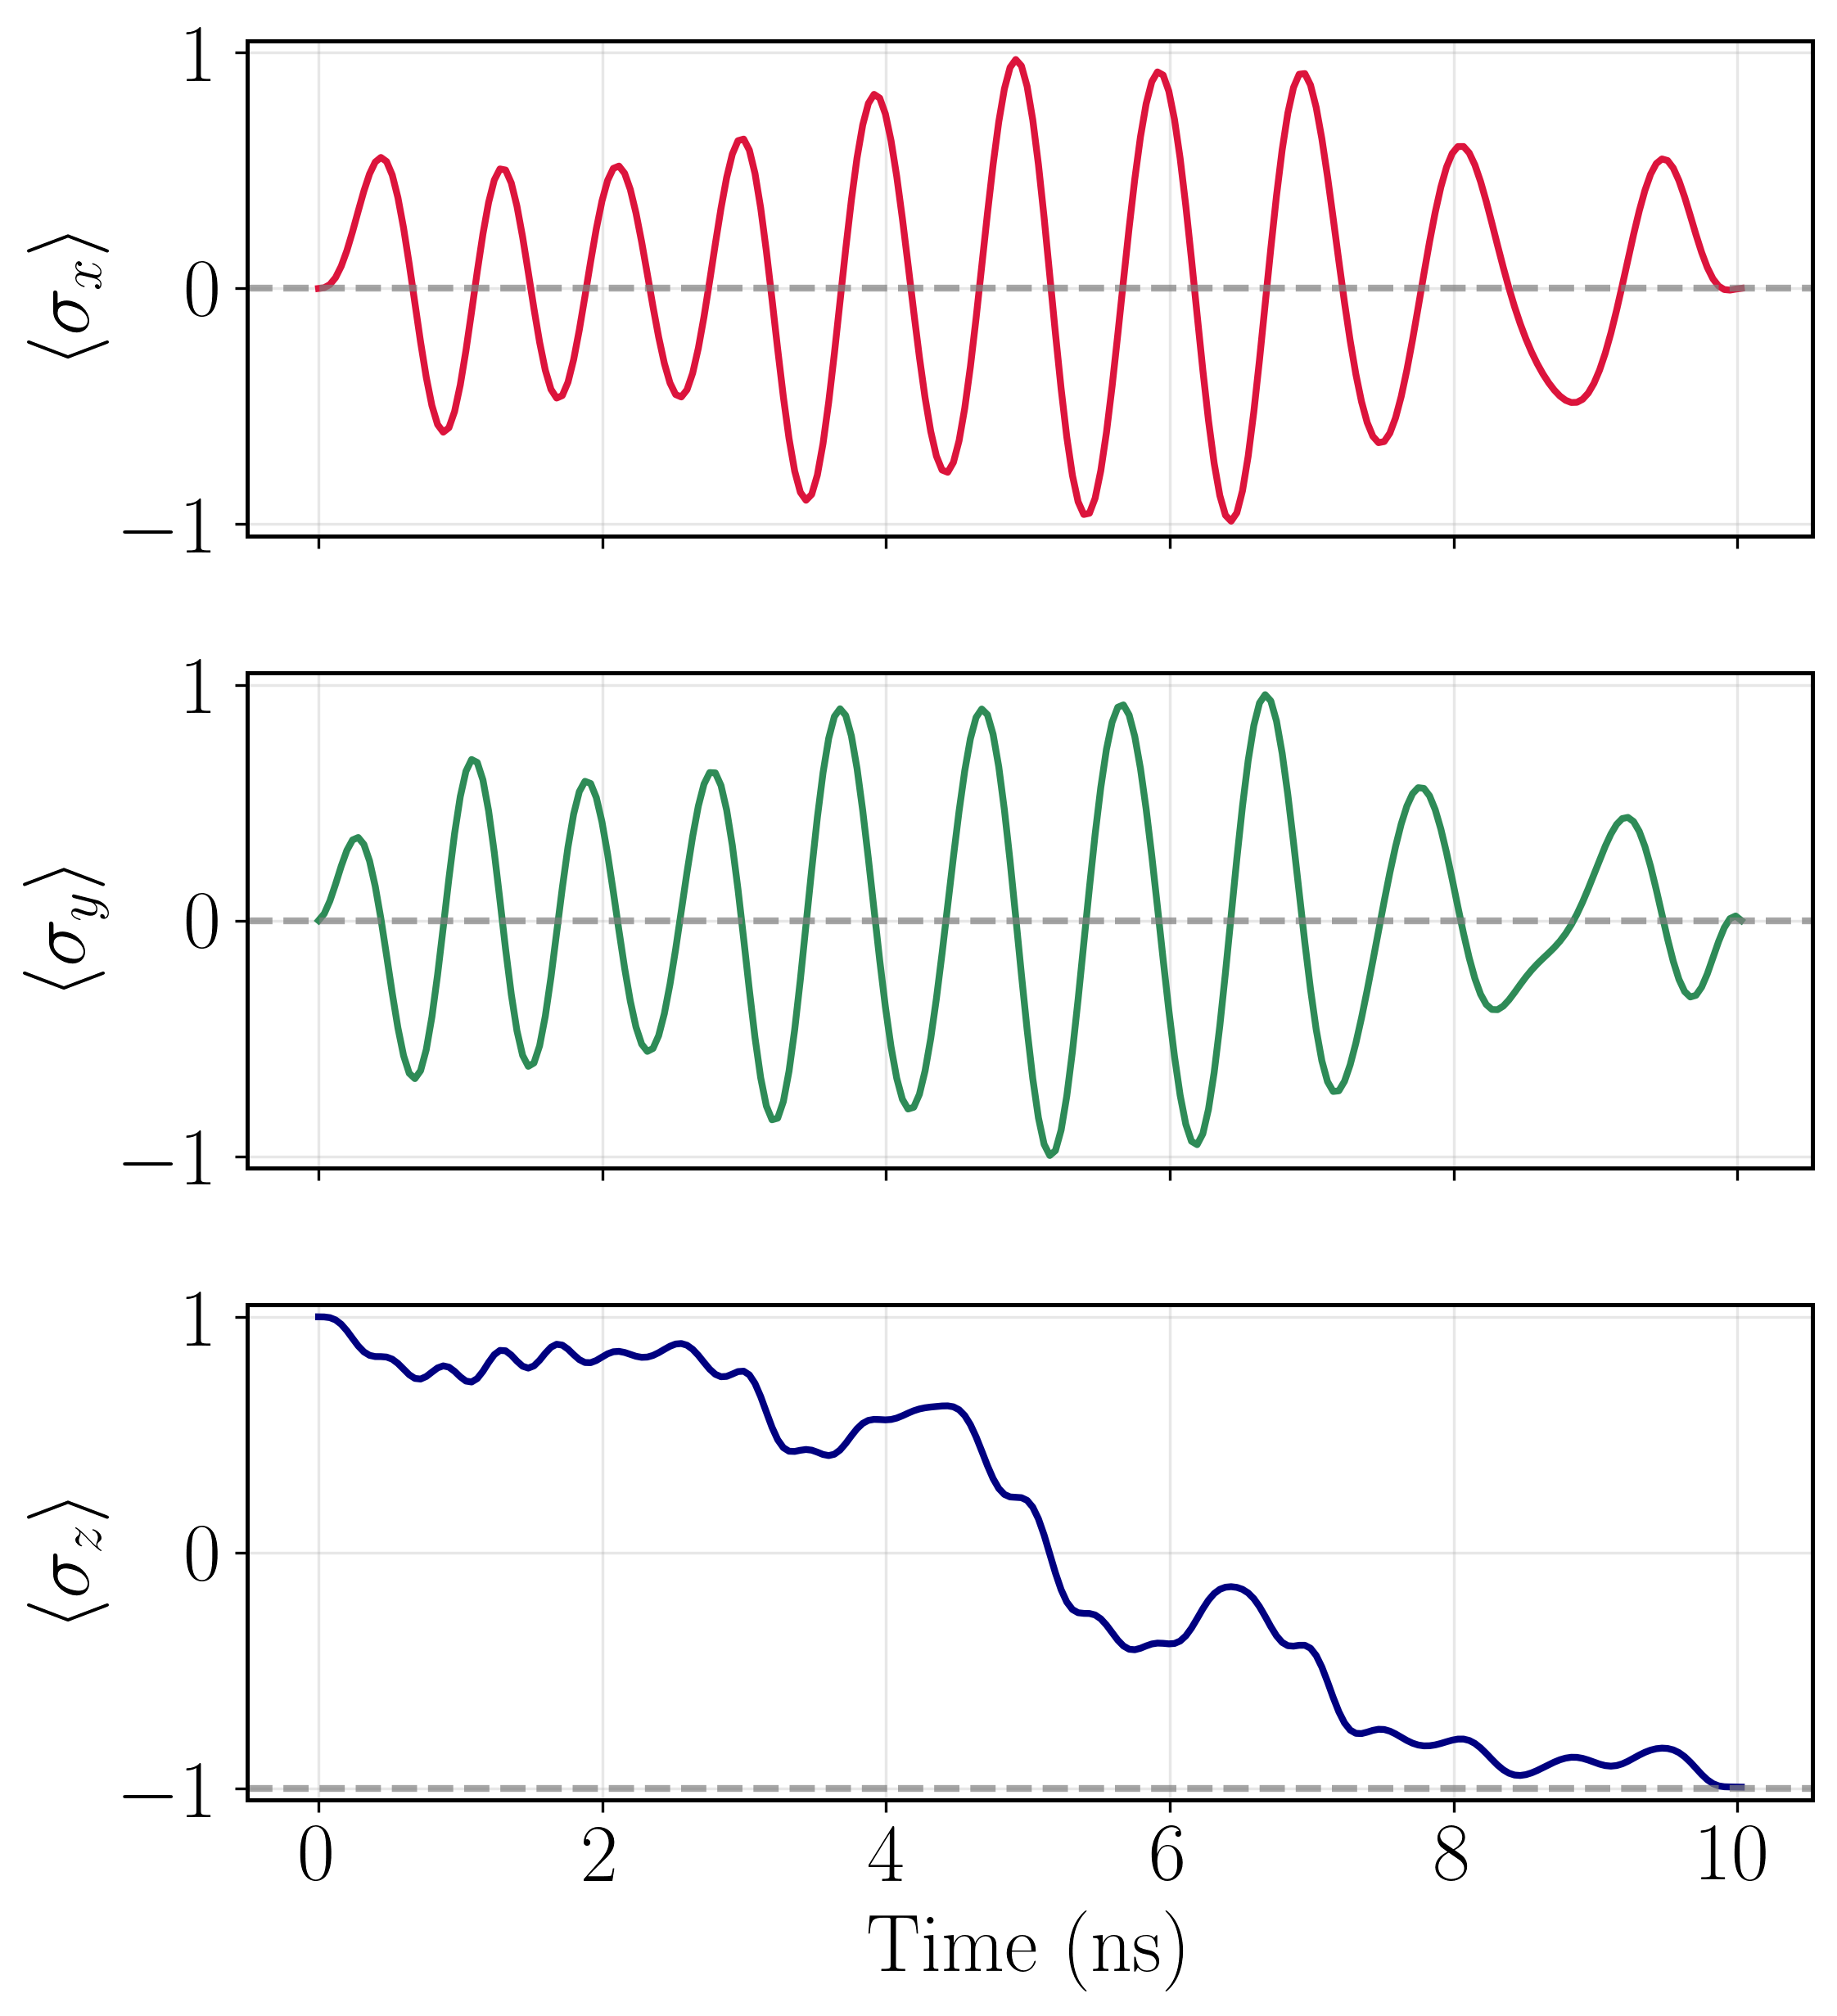

Figure saved: results/x_gate_bloch_trajectory.png


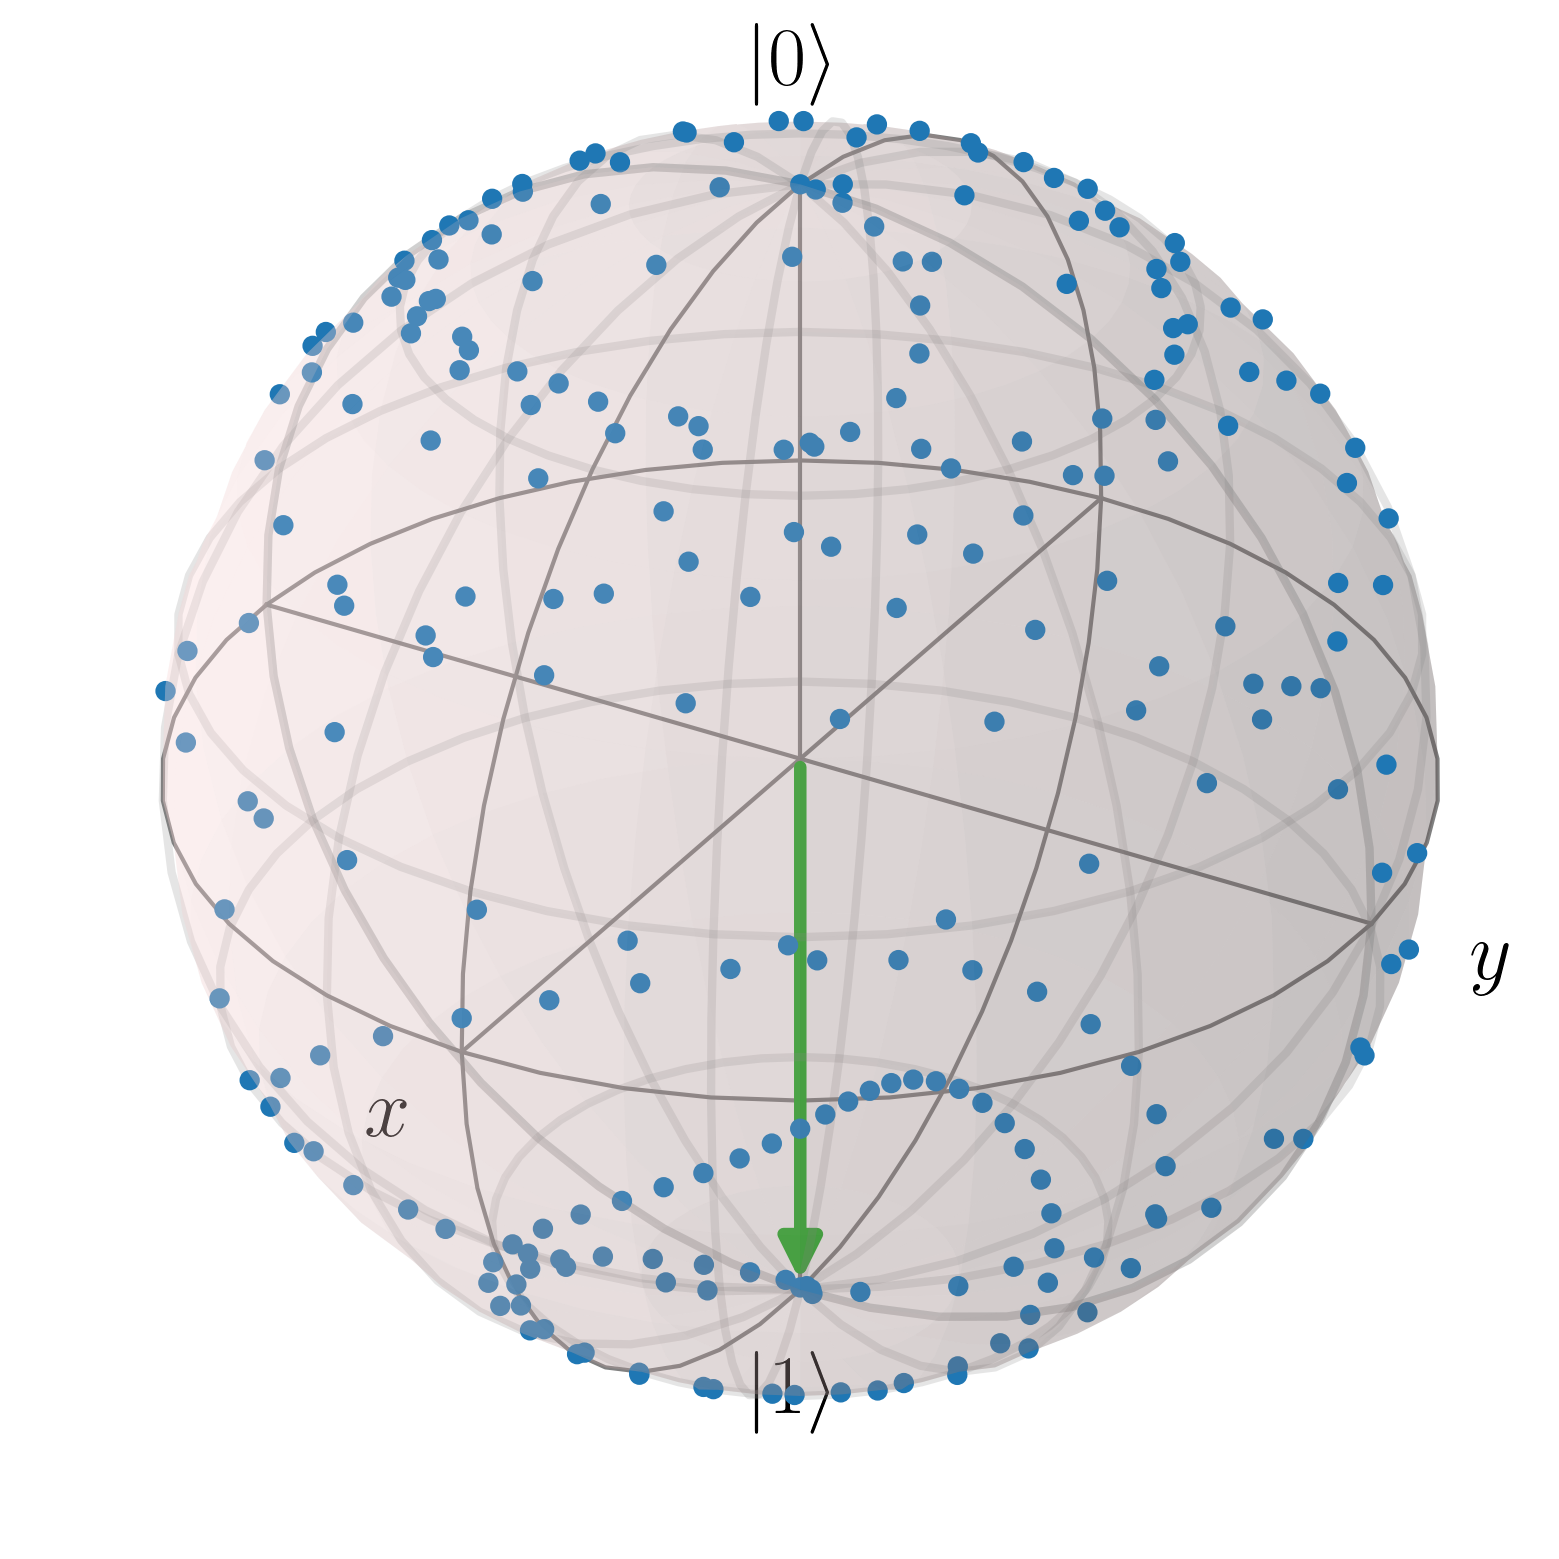

Figure saved: results/x_gate_control_field_analysis.png


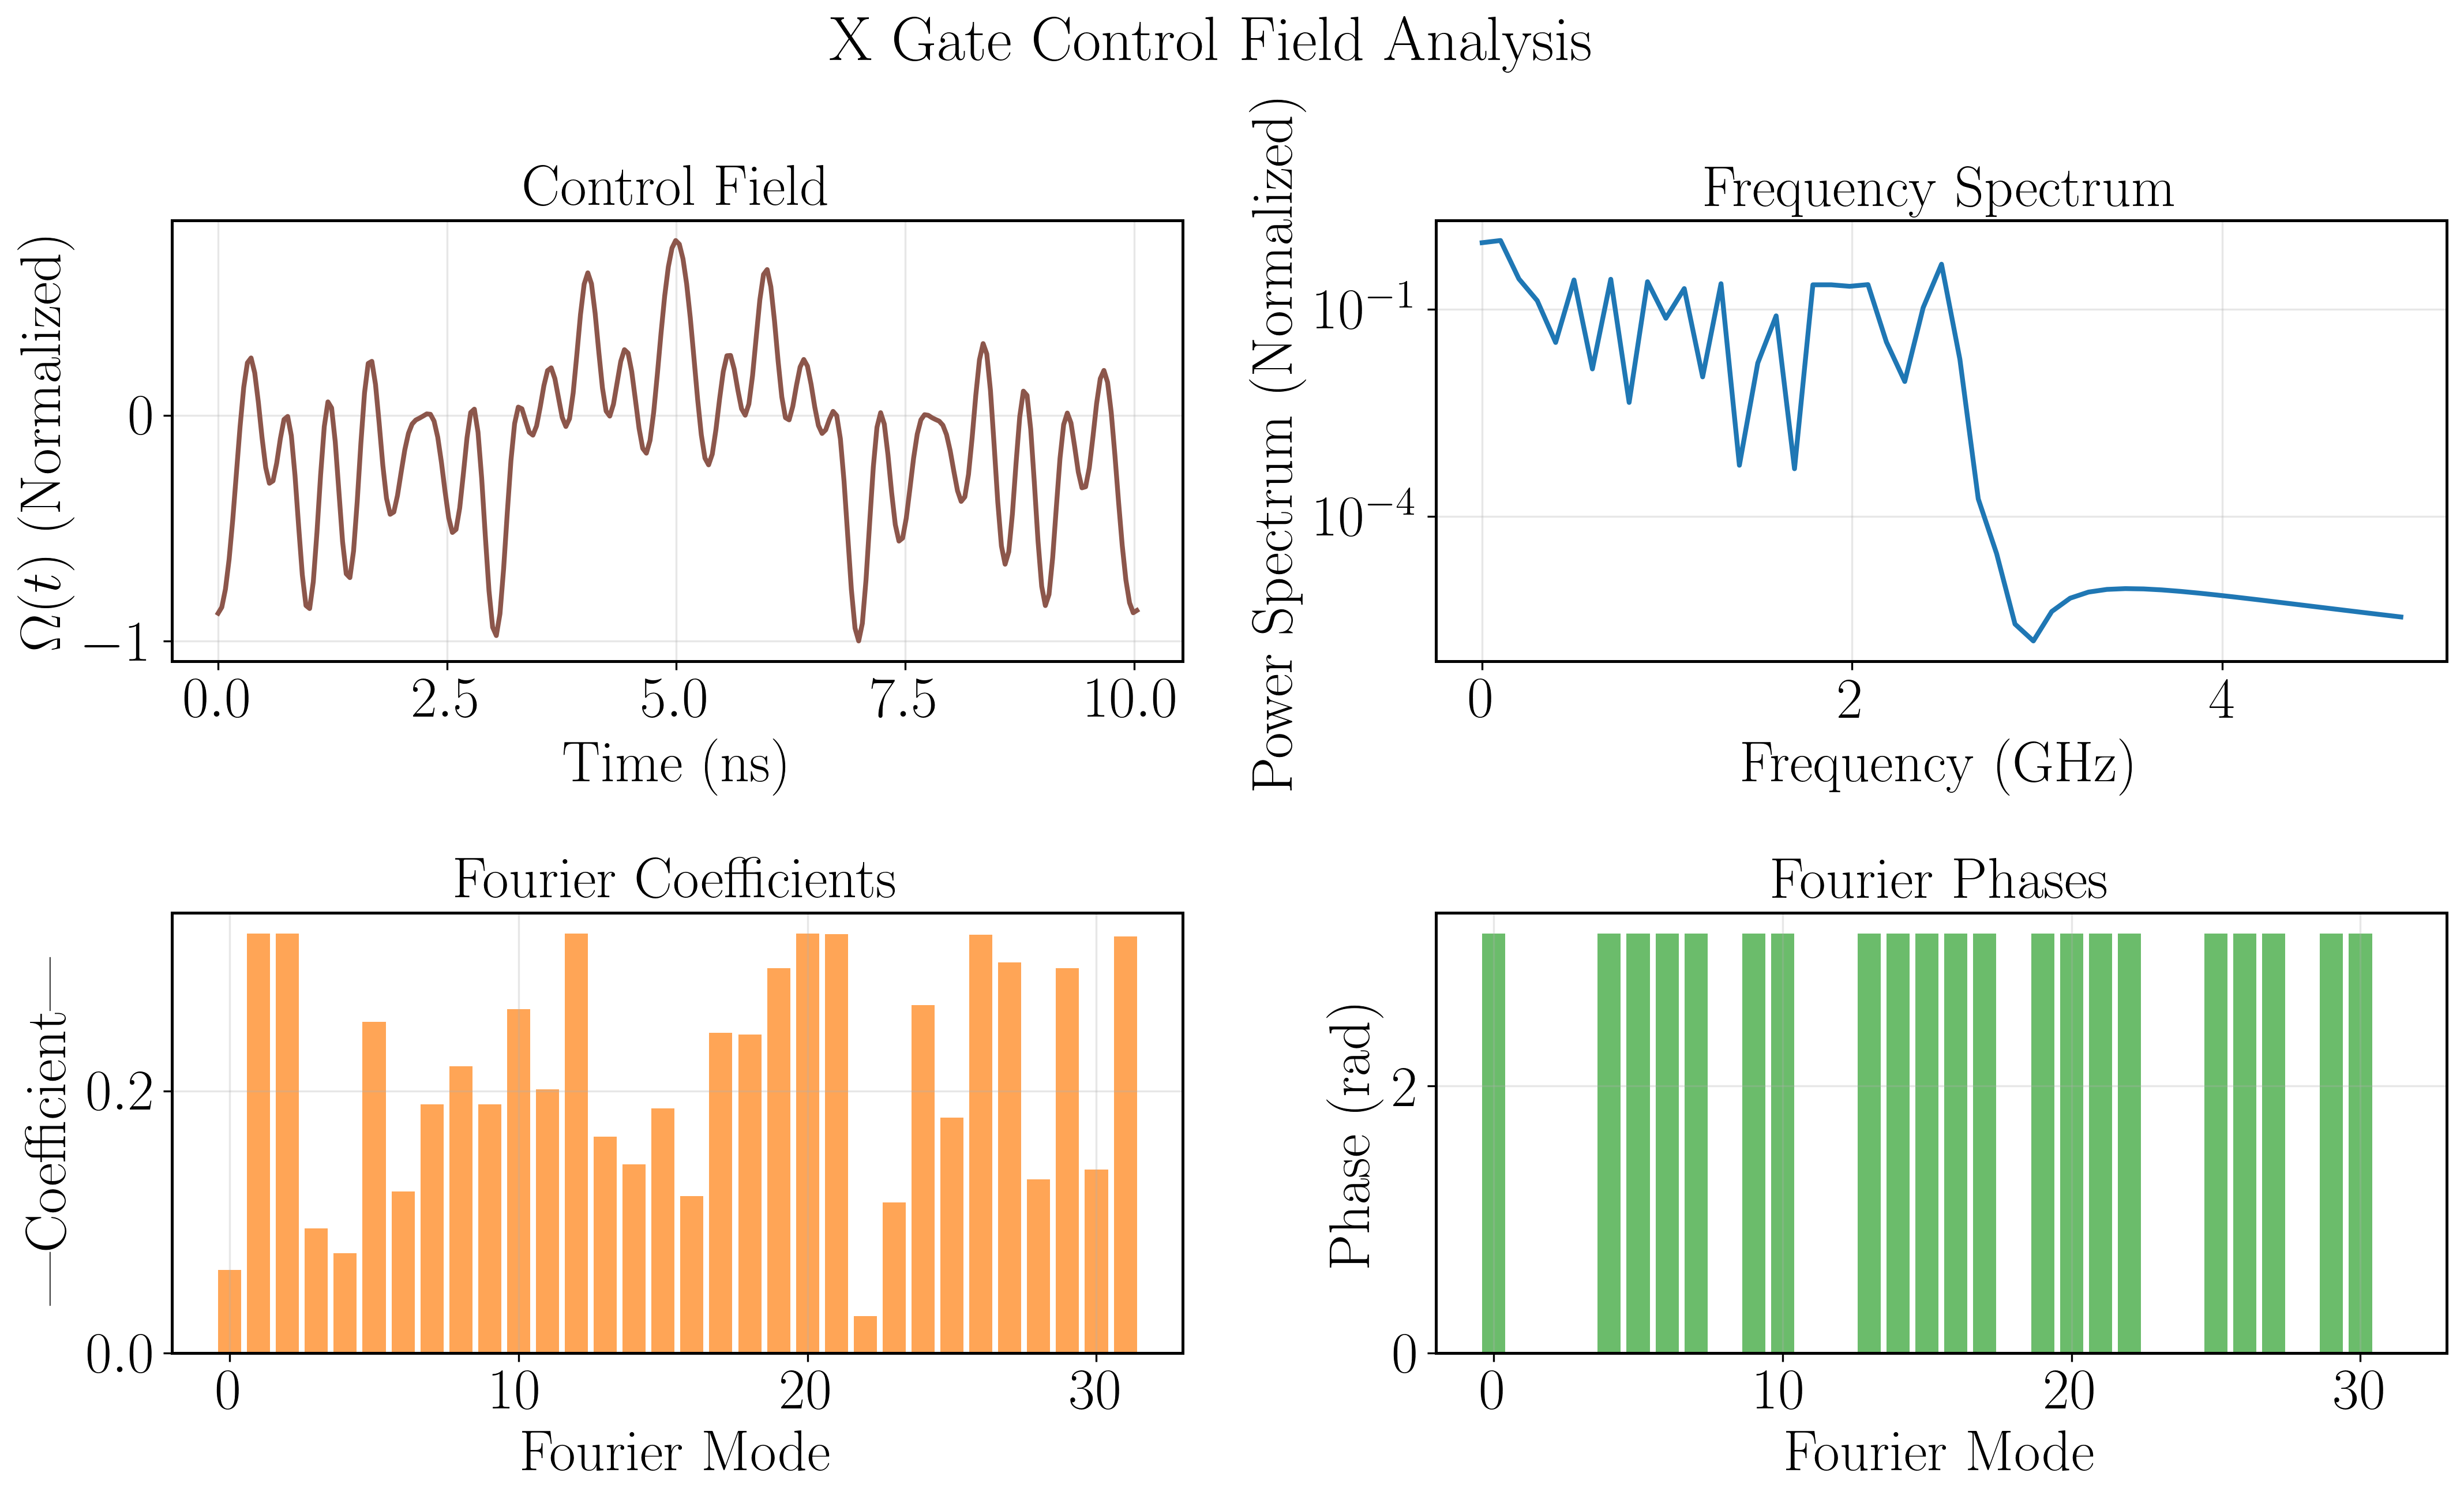

X Gate final Bloch vector: [0.0004293259217479625, 0.0002069939599511009, -0.9952843356610062]
X Gate ideal Bloch vector: [0.0, 0.0, -1.0]
X Gate Bloch vector error (L2): 0.0047
X Gate fidelity (stored): 0.9999


In [58]:
# X Gate: Refactored Plotting Using Plotting Module
x_opt_coeffs = gate_results['x_gate']['result']['optimization_result'].x
x_opt_period = gate_results['x_gate']['result']['control_period']
control_field_x = compute_fourier_control_field(time_array, x_opt_coeffs, x_opt_period)
ex_x, ey_x, ez_x = gate_results['x_gate']['traj']
ideal_vec_x = ideal_bloch['x_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=True, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_x, ey_x, ez_x, ideal_vector=ideal_vec_x, 
                                   gate_name='X Gate', filename='x_gate_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_x, ey_x, ez_x, ideal_vector=ideal_vec_x, 
                                   gate_name='X Gate', filename='x_gate_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_x.real, 
                                         fourier_coefficients=x_opt_coeffs, title='X Gate Control Field Analysis', filename='x_gate_control_field_analysis.png')

final_vec_x = [ex_x[-1], ey_x[-1], ez_x[-1]]
err_x = np.linalg.norm(np.array(final_vec_x) - np.array(ideal_vec_x))
print(f"X Gate final Bloch vector: {final_vec_x}")
print(f"X Gate ideal Bloch vector: {ideal_vec_x}")
print(f"X Gate Bloch vector error (L2): {err_x:.4f}")
print(f"X Gate fidelity (stored): {gate_results['x_gate']['fidelity']:.4f}")

In [8]:
initial_guess_x = np.load('data/x_gate_prediction.npz')['prediction_physical'][0]
initial_guess_x.shape

(32,)

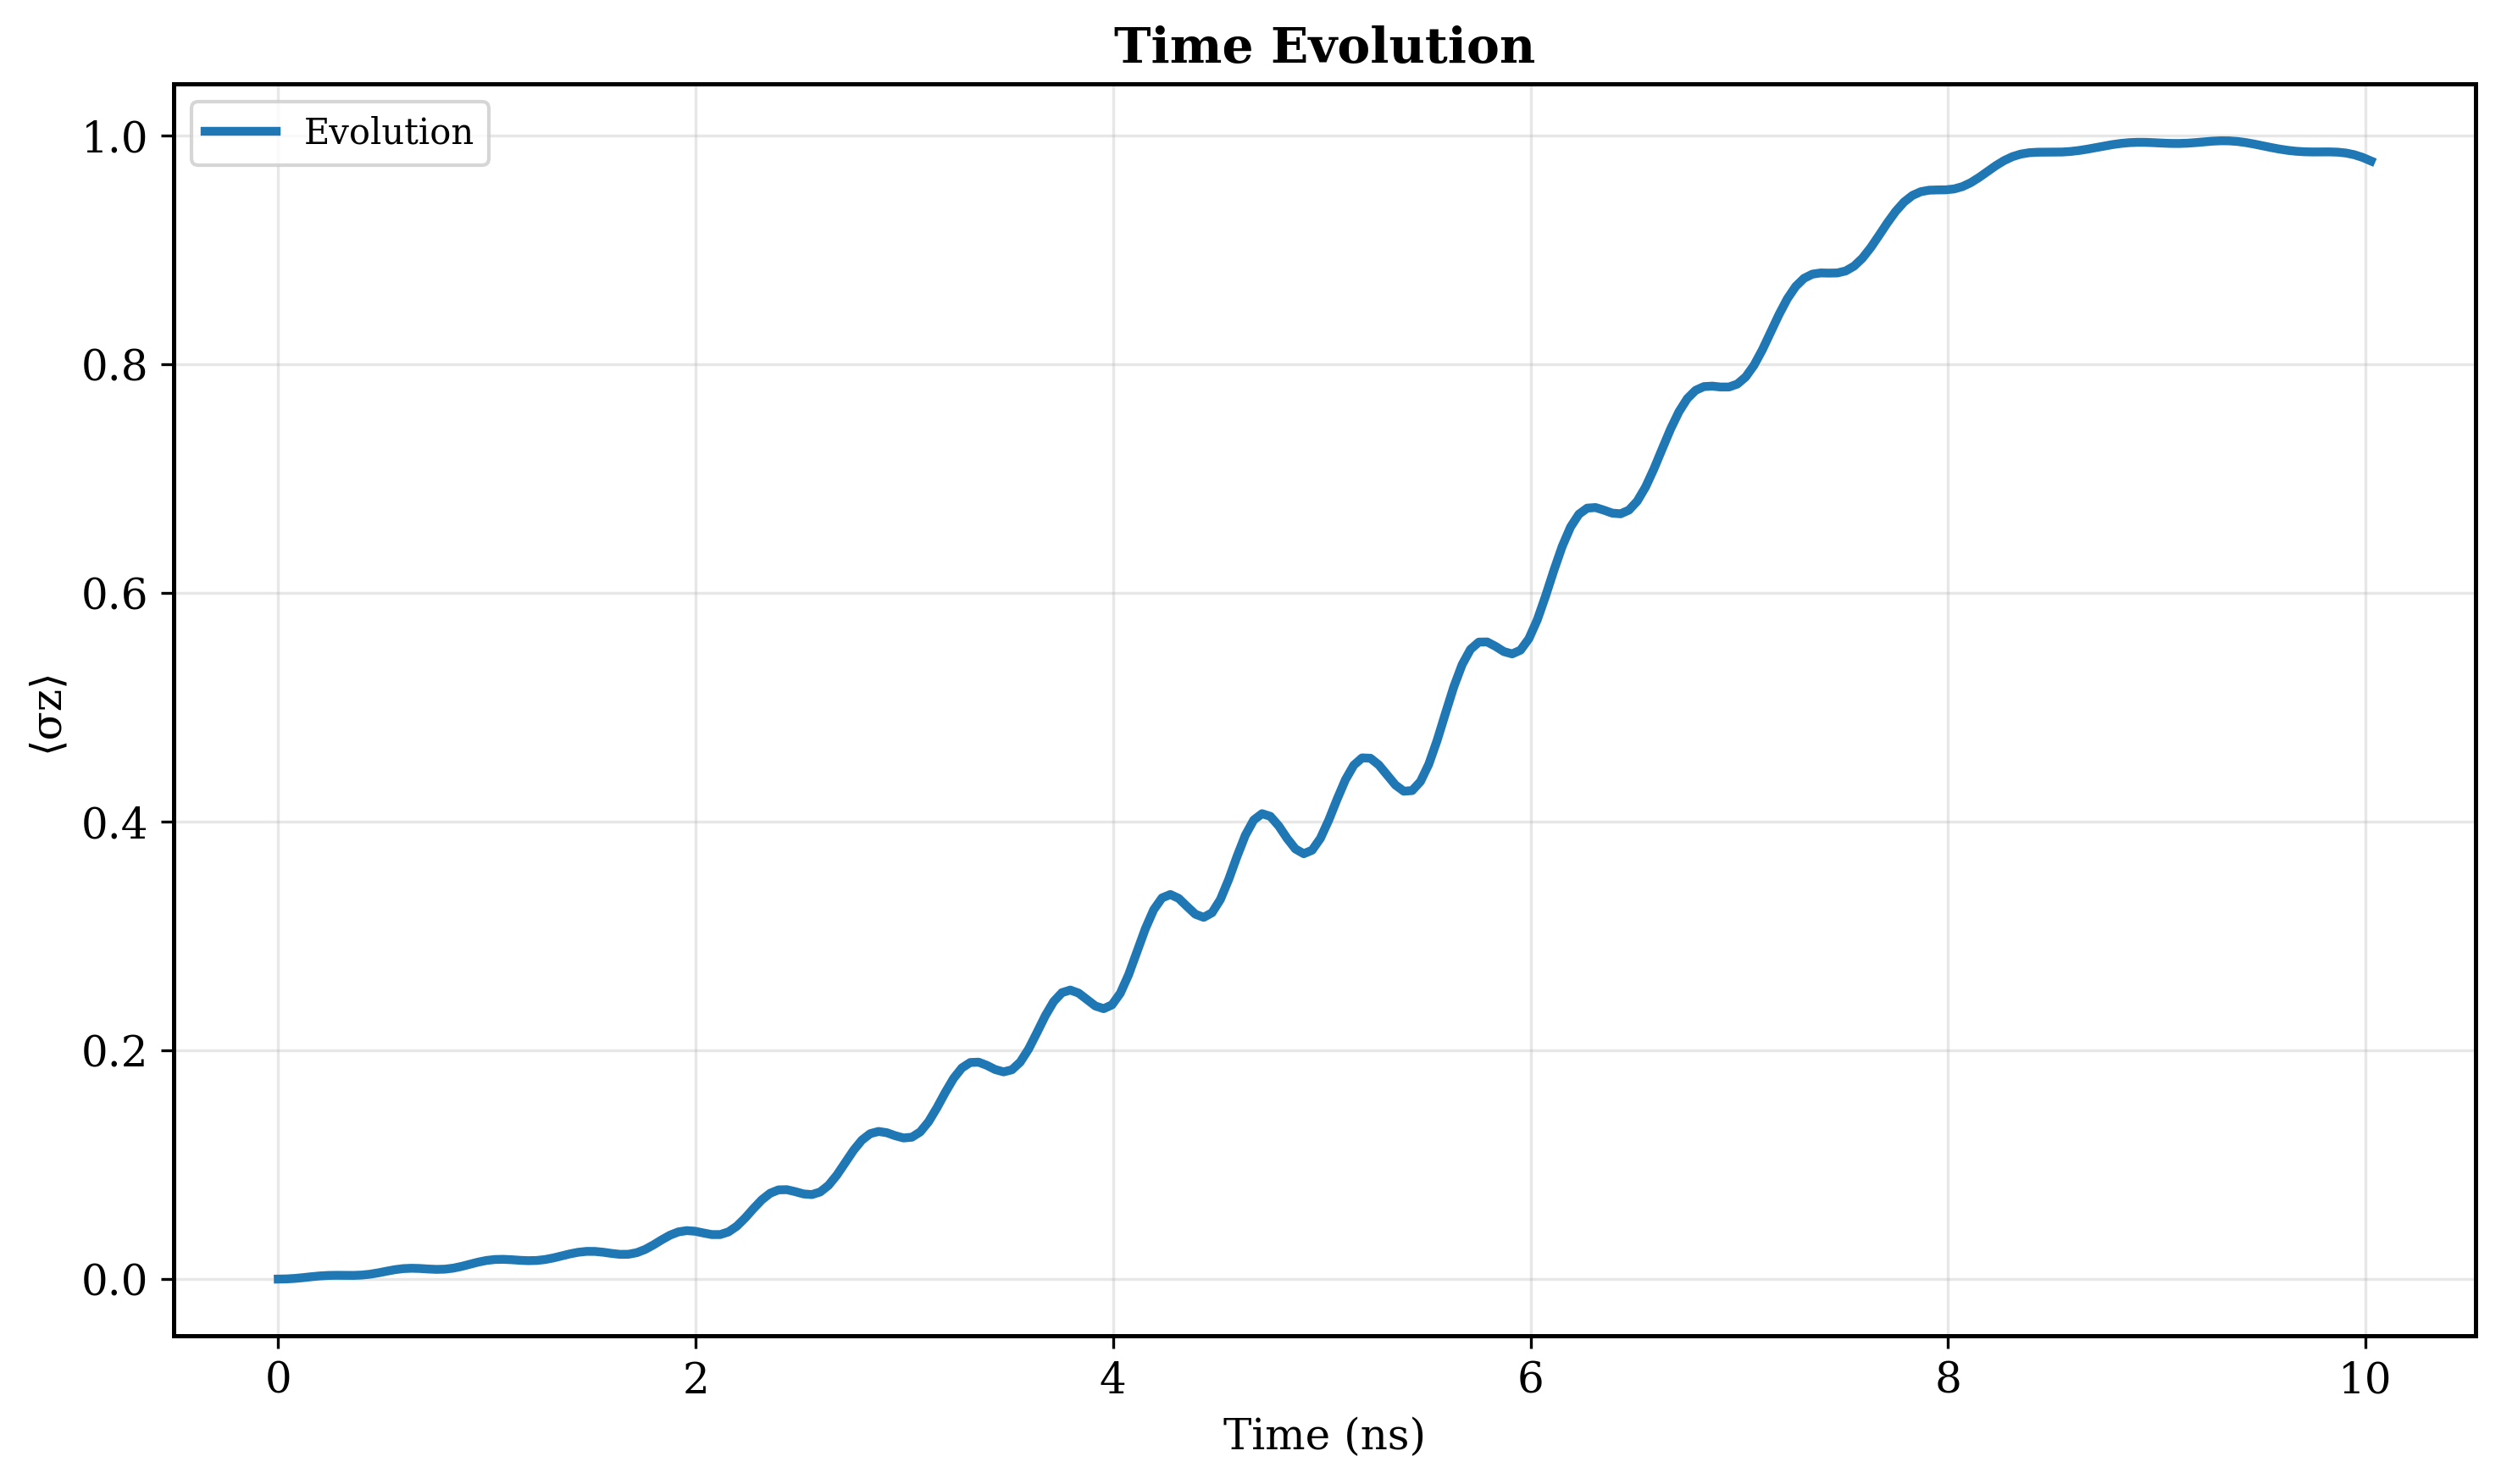

In [9]:
guess_result = simulate_controlled_evolution(
    time_array, initial_guess_x,
    time_array[-1],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)

plotter_guess = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

plotter_guess.plot_time_evolution(time_array,
                            guess_result['expect'][-1], ylabel='⟨σz⟩')


In [10]:
# Run X gate optimization with Neural Network initial guess
start = time.time()
x_opt_res_NN = optimize_x_gate(
    fourier_modes=16, max_iterations=1,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=initial_guess_x
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
x_opt_sim_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_NN['optimization_result'].x,
    drive_period=x_opt_res_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim_NN['states'])

# Store
x_opt_cost_NN = x_opt_res_NN['optimization_result'].fun
x_opt_fid_NN = 1 - x_opt_cost_NN
gate_results['x_gate_NN'] = {
    'result': x_opt_res_NN,
    'traj': (ex_x, ey_x, ez_x),
    'cost': x_opt_cost_NN,
    'fidelity': x_opt_fid_NN,
    'nfev': x_opt_res_NN['nfev'],
    'time_elapsed': elapsed
}

print(f"X_NN gate optimization complete: cost={x_opt_cost_NN:.3e}, fidelity={x_opt_fid_NN:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_NN['nfev']}")

Starting optimization with provided initial guess...
Parameter space dimension: 32
Optimization method: L-BFGS-B
Variable bounds: (np.float64(-0.32), np.float64(0.32))
------------------------------------------------------------
Cost = 1.284880e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.284880e-04
Optimization success: True
Function evaluations: 396
X_NN gate optimization complete: cost=1.285e-04, fidelity=0.9999, time=49.05s
Time elapsed: 49.05 seconds
Total function evaluations: 396


In [11]:
x_opt_res_NN = np.load(f'data/payloads/x_gate/x_opt_res_NN.npz', allow_pickle=True)['x_opt_res_NN'].item()

# Simulate trajectory with optimal coefficients
x_opt_sim_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_NN['optimization_result'].x,
    drive_period=x_opt_res_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim_NN['states'])

# Store
x_opt_cost_NN = x_opt_res_NN['optimization_result'].fun
x_opt_fid_NN = 1 - x_opt_cost_NN
gate_results['x_gate_NN'] = {
    'result': x_opt_res_NN,
    'traj': (ex_x, ey_x, ez_x),
    'cost': x_opt_cost_NN,
    'fidelity': x_opt_fid_NN,
    'nfev': x_opt_res_NN['nfev'],
    'time_elapsed': 49.05
}

print(f"X_NN gate optimization complete: cost={x_opt_cost_NN:.3e}, fidelity={x_opt_fid_NN:.4f}, time={49.05:.2f}s")
print(f"Time elapsed: {49.05:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_NN['nfev']}")

X_NN gate optimization complete: cost=1.285e-04, fidelity=0.9999, time=49.05s
Time elapsed: 49.05 seconds
Total function evaluations: 396


Figure saved: results/x_gate_NN_bloch_components.png


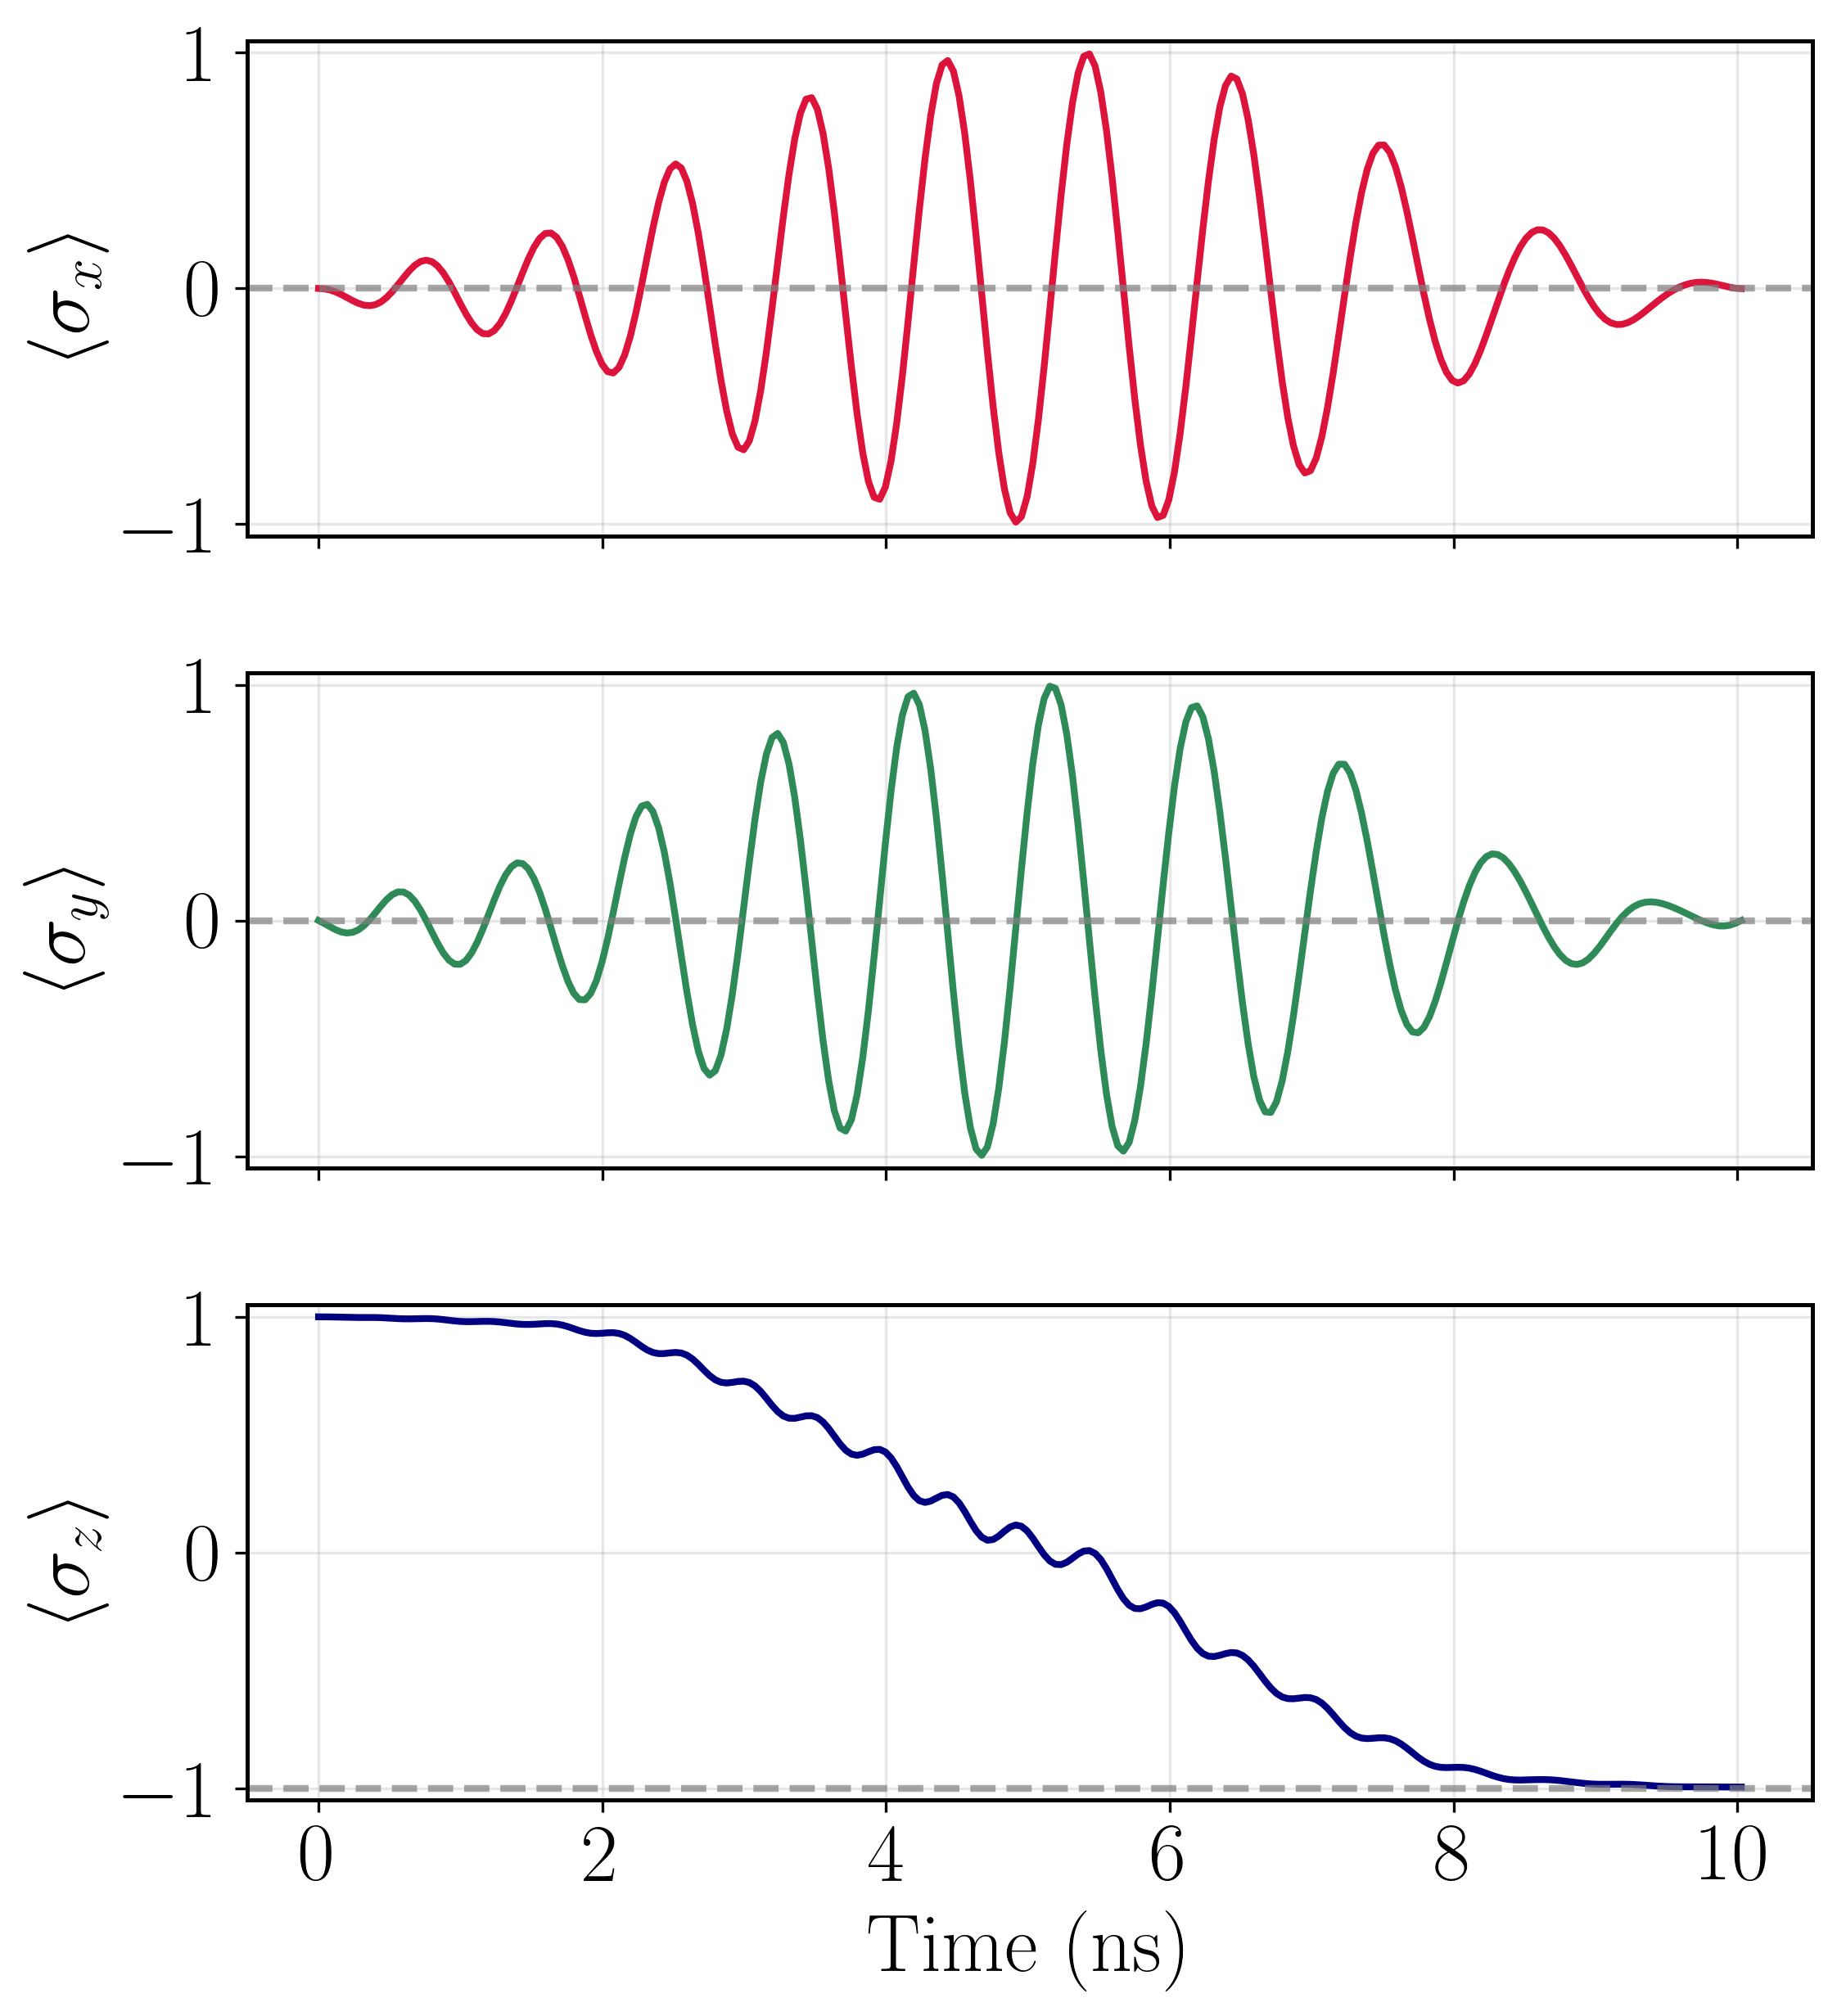

Figure saved: results/x_gate_NN_bloch_trajectory.png


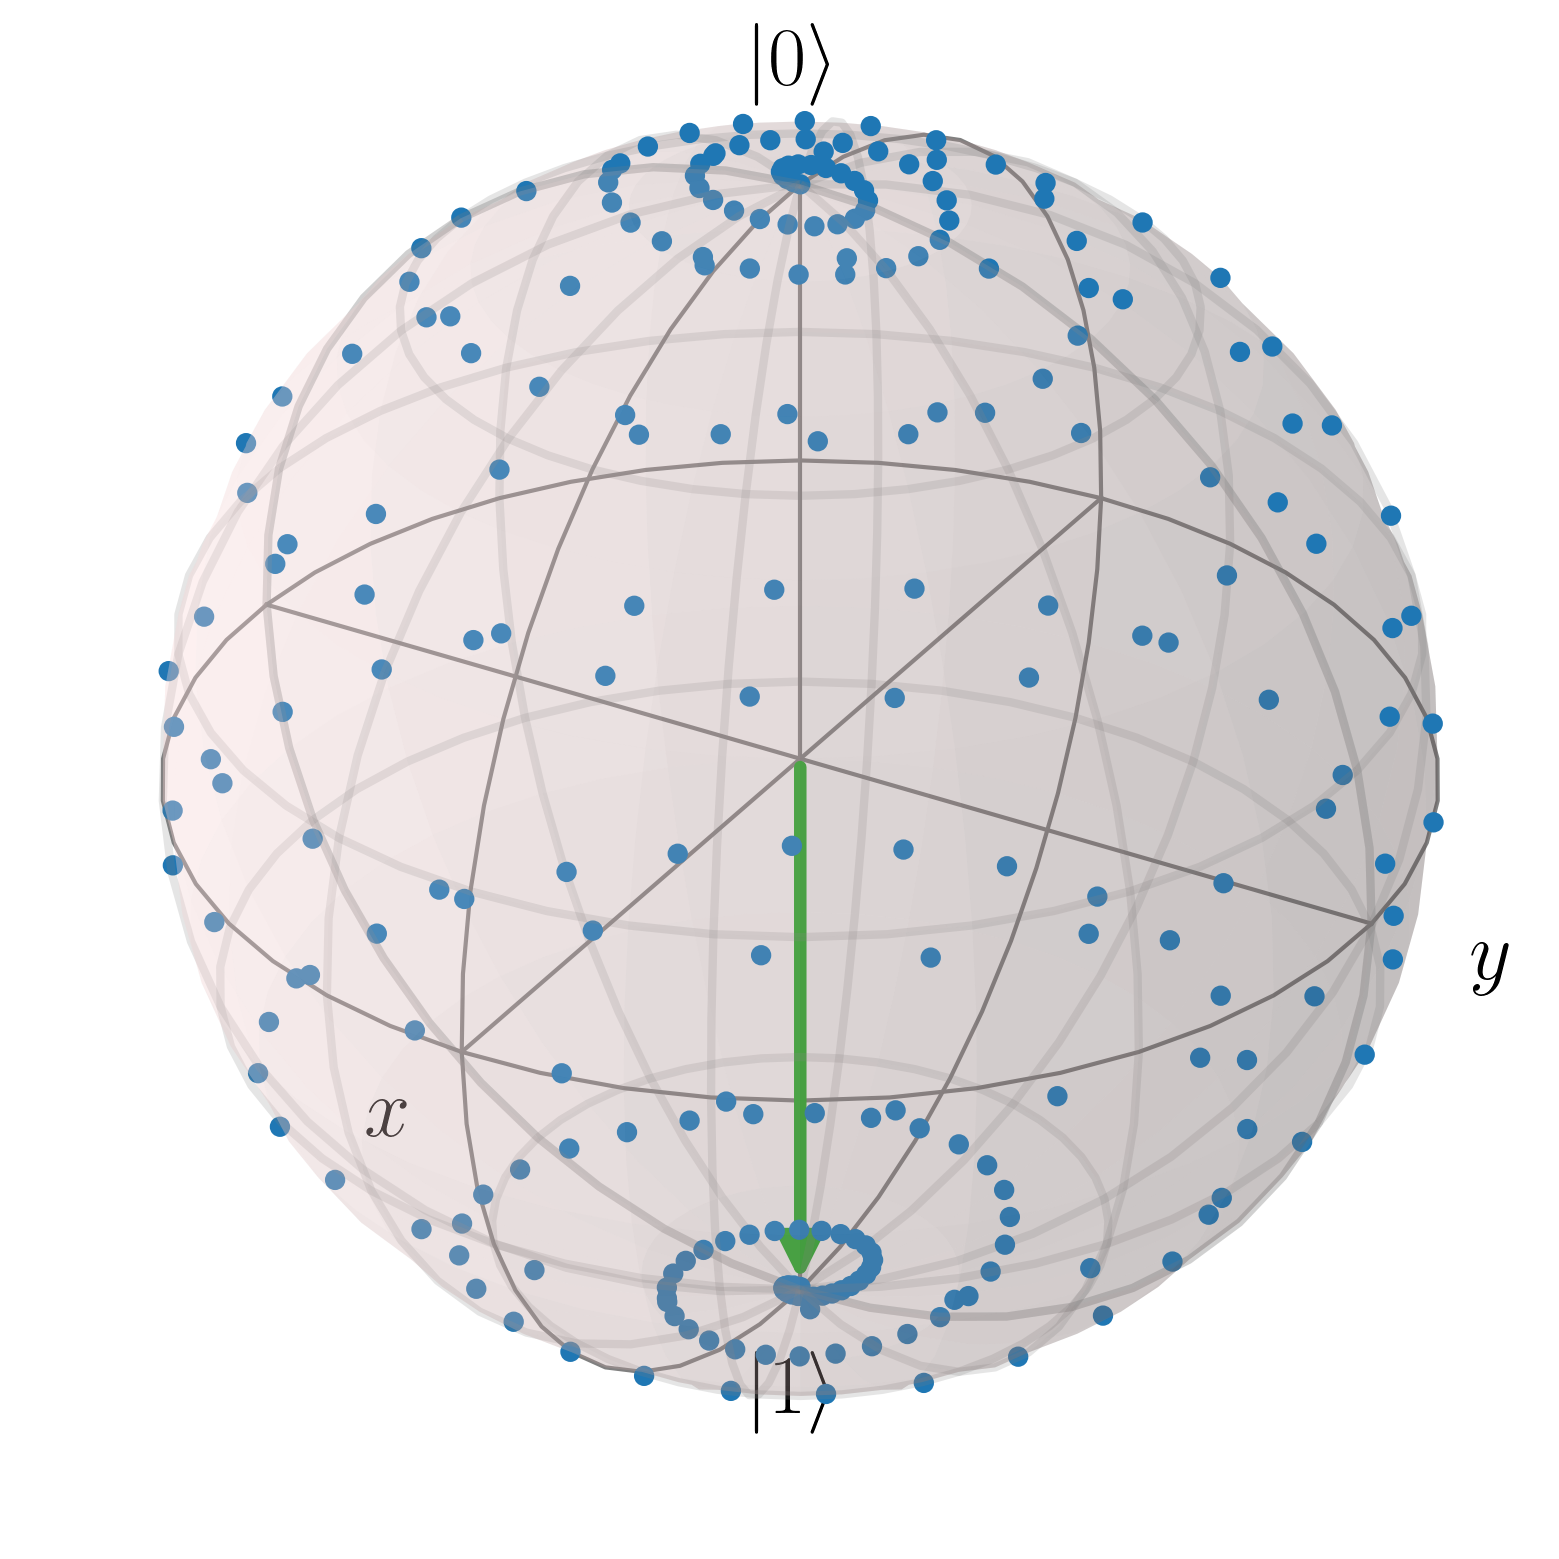

Figure saved: results/x_gate_NN_control_field_analysis.png


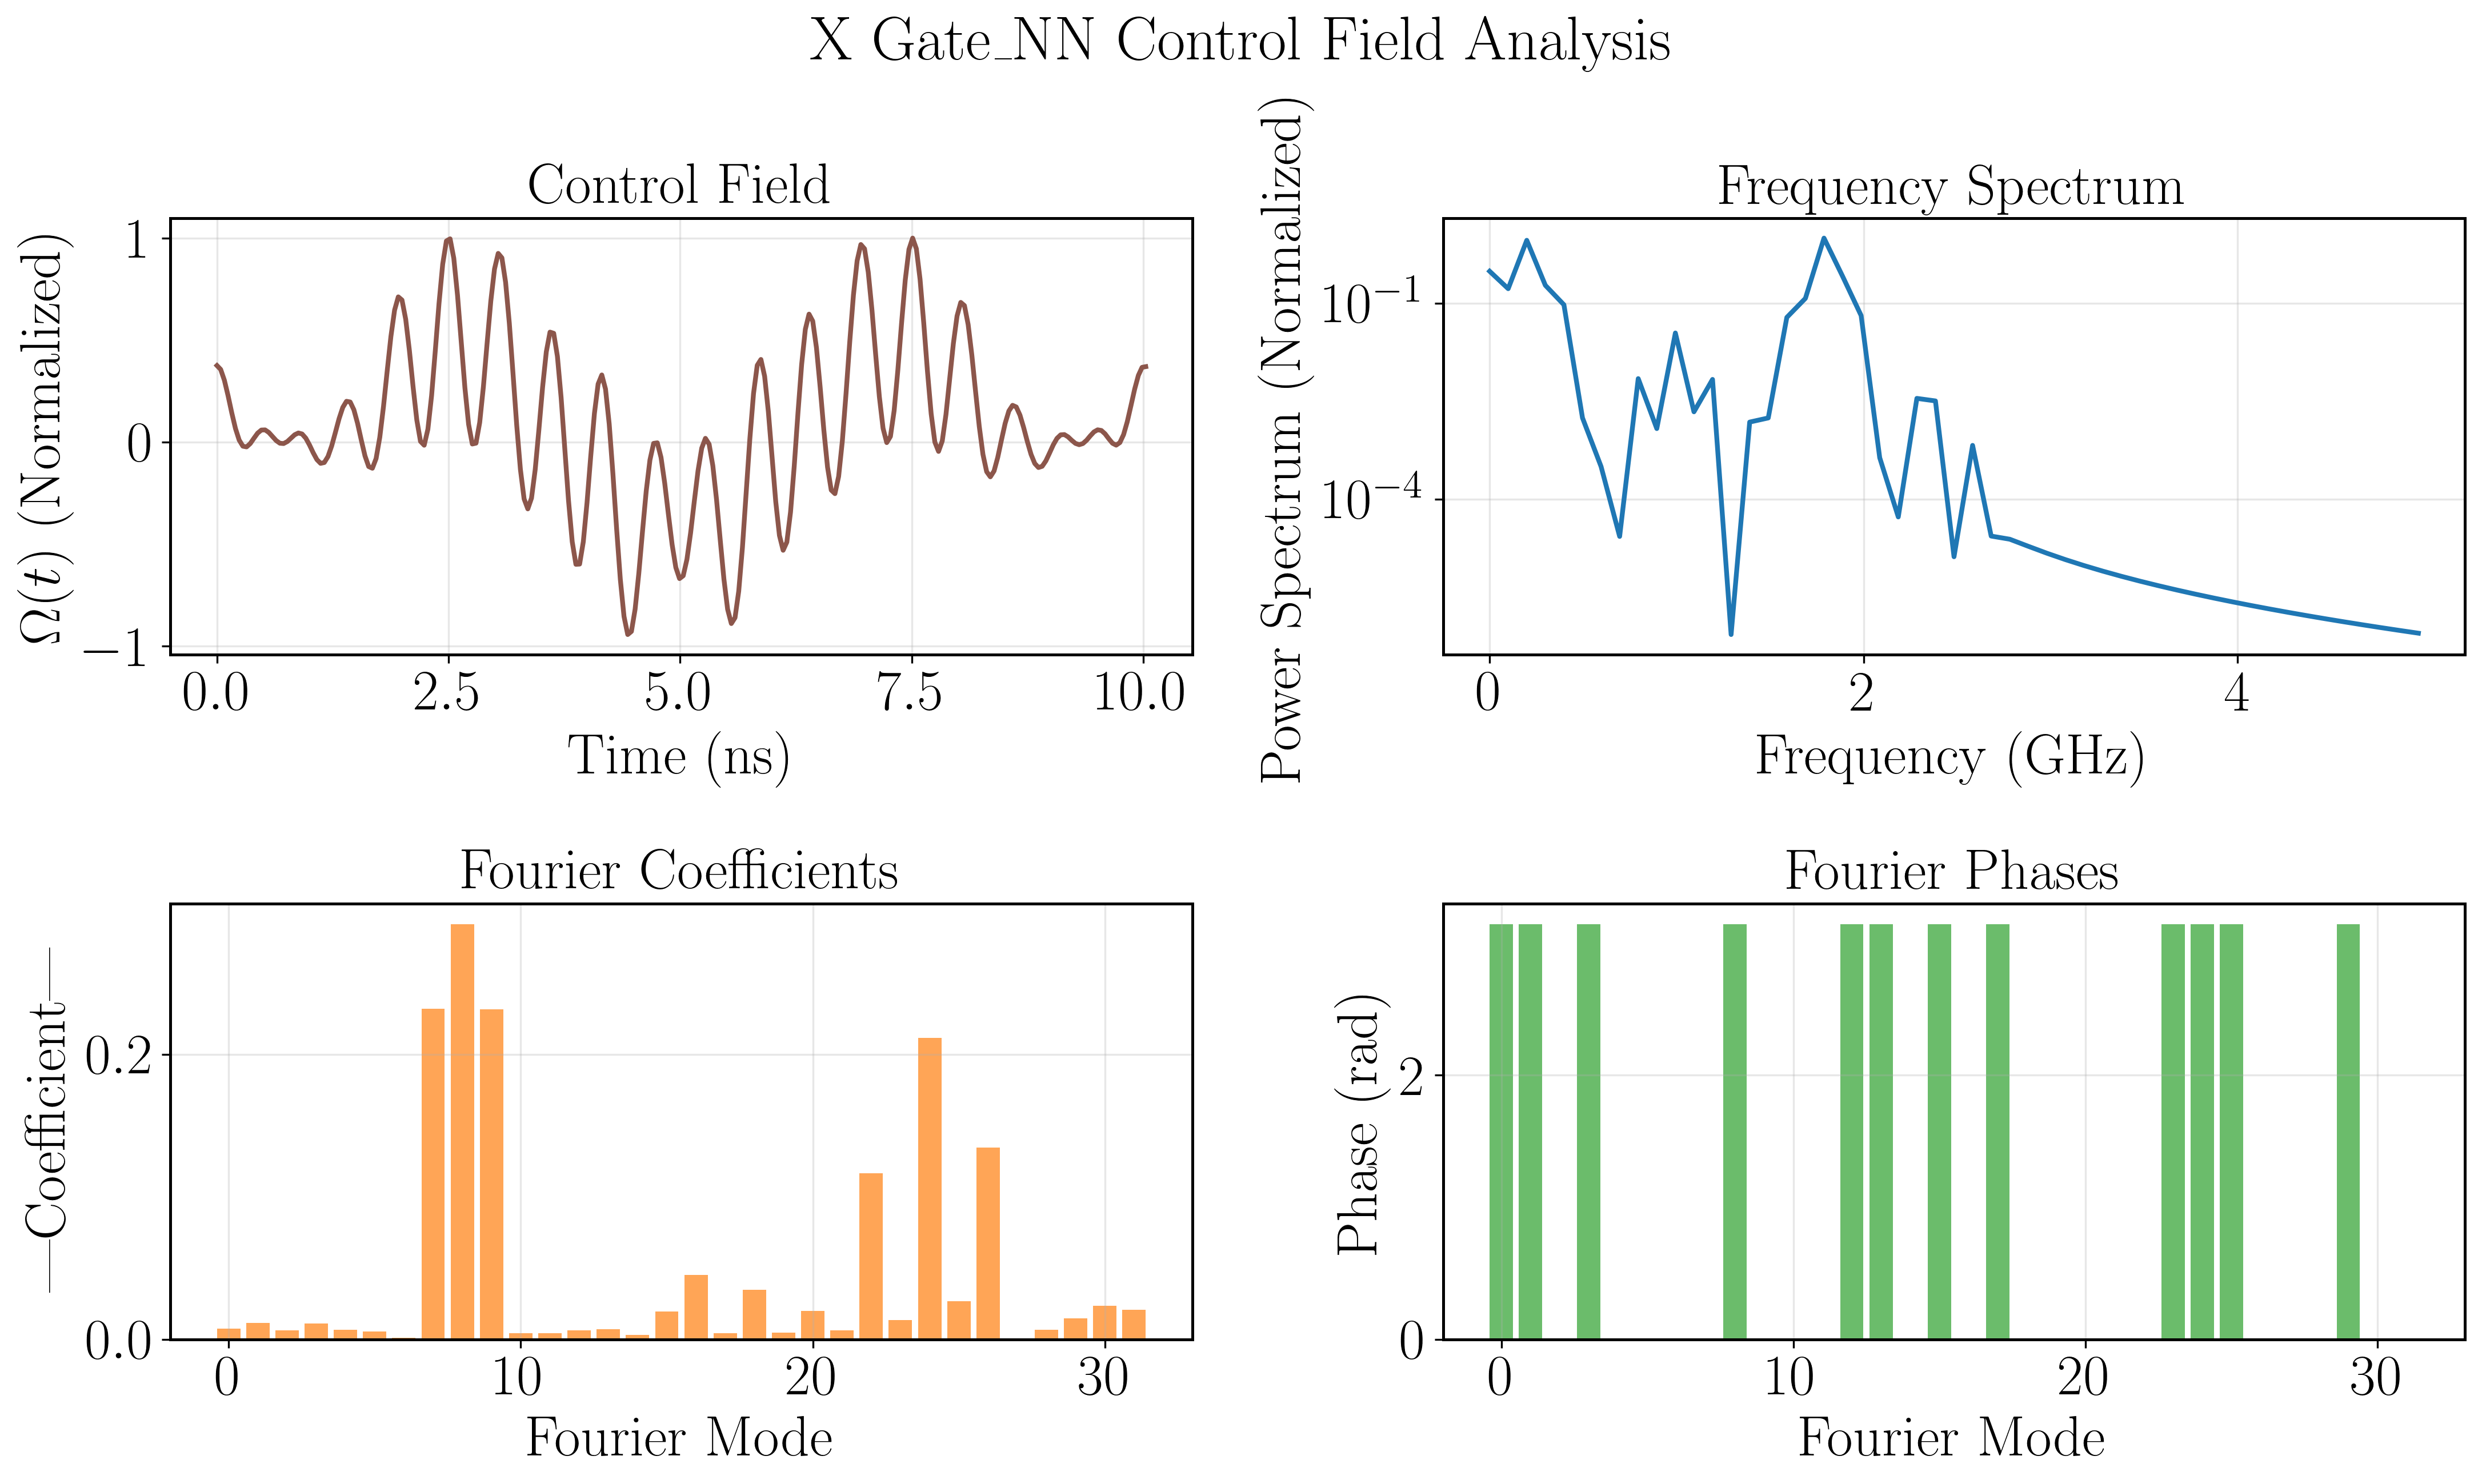

X Gate_NN final Bloch vector: [-0.0005698772123020057, 0.000142361771443855, -0.9950427187991829]
X Gate_NN ideal Bloch vector: [0.0, 0.0, -1.0]
X Gate_NN Bloch vector error (L2): 0.0050
X Gate_NN fidelity (stored): 0.9999


In [59]:
# X Gate_NN: Refactored Plotting Using Plotting Module
x_opt_coeffs_NN = gate_results['x_gate_NN']['result']['optimization_result'].x
x_opt_period_NN = gate_results['x_gate_NN']['result']['control_period']
control_field_x_NN = compute_fourier_control_field(time_array, 
                                                   x_opt_coeffs_NN, 
                                                   x_opt_period_NN)
ex_x_NN, ey_x_NN, ez_x_NN = gate_results['x_gate_NN']['traj']
ideal_vec_x_NN = ideal_bloch['x_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_x_NN, ey_x_NN, ez_x_NN, ideal_vector=ideal_vec_x_NN, 
                                   gate_name='X Gate_NN', filename='x_gate_NN_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_x_NN, ey_x_NN, ez_x_NN, ideal_vector=ideal_vec_x_NN, 
                                   gate_name='X Gate_NN', filename='x_gate_NN_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_x_NN.real, 
                                         fourier_coefficients=x_opt_coeffs_NN, 
                                         title='X Gate_NN Control Field Analysis', filename='x_gate_NN_control_field_analysis.png')

final_vec_x_NN = [ex_x_NN[-1], ey_x_NN[-1], ez_x_NN[-1]]
err_x_NN = np.linalg.norm(np.array(final_vec_x_NN) - np.array(ideal_vec_x_NN))
print(f"X Gate_NN final Bloch vector: {final_vec_x_NN}")
print(f"X Gate_NN ideal Bloch vector: {ideal_vec_x_NN}")
print(f"X Gate_NN Bloch vector error (L2): {err_x_NN:.4f}")
print(f"X Gate_NN fidelity (stored): {gate_results['x_gate_NN']['fidelity']:.4f}")

In [ ]:
# Run X gate optimization - Nelder-Mead
start = time.time()
x_opt_res_nm = optimize_x_gate(
    fourier_modes=16, max_iterations=6,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=None, optimization_method='Nelder-Mead'
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
x_opt_sim_nm = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_nm['optimization_result'].x,
    drive_period=x_opt_res_nm['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x_nm, ey_x_nm, ez_x_nm = extract_qubit_expectations(x_opt_sim_nm['states'])

# Store
x_opt_cost_nm = x_opt_res_nm['optimization_result'].fun
x_opt_fid_nm = 1 - x_opt_cost_nm
gate_results['x_gate_nm'] = {
    'result': x_opt_res_nm,
    'traj': (ex_x_nm, ey_x_nm, ez_x_nm),
    'cost': x_opt_cost_nm,
    'fidelity': x_opt_fid_nm,
    'time_elapsed': elapsed
}

print(f"X gate_nm optimization complete: cost={x_opt_cost_nm:.3e}, fidelity={x_opt_fid_nm:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_nm['nfev']}")

Starting global optimization with 6 random initializations...
Parameter space dimension: 32
Optimization method: Nelder-Mead
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------


/home/bustos/projects/tgRepo_qubitControl/src/optimization.py:128: OptimizeWarning: Initial guess is not within the specified bounds
  best_result = minimize(


Iteration 1: Parameters = 32, Cost = 1.287648e-04


/home/bustos/projects/tgRepo_qubitControl/src/optimization.py:142: OptimizeWarning: Initial guess is not within the specified bounds
  current_result = minimize(


Iteration 2: Parameters = 32, Cost = 1.233942e-04
  → New best solution found!
Iteration 3: Parameters = 32, Cost = 1.266588e-04
Iteration 4: Parameters = 32, Cost = 1.295583e-04
Iteration 5: Parameters = 32, Cost = 1.252698e-04
Iteration 6: Parameters = 32, Cost = 1.263637e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.233942e-04
Optimization success: False
Function evaluations: 6400
X gate_nm optimization complete: cost=1.234e-04, fidelity=0.9999, time=3592.04s
Time elapsed: 3592.04 seconds


KeyError: 'result'

In [15]:
x_opt_res_nm = np.load(f'data/payloads/x_gate/x_opt_res_nm.npz', allow_pickle=True)['x_opt_res_nm'].item()

# Simulate trajectory with optimal coefficients
x_opt_sim_nm = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_nm['optimization_result'].x,
    drive_period=x_opt_res_nm['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x_nm, ey_x_nm, ez_x_nm = extract_qubit_expectations(x_opt_sim_nm['states'])

# Store
x_opt_cost_nm = x_opt_res_nm['optimization_result'].fun
x_opt_fid_nm = 1 - x_opt_cost_nm
gate_results['x_gate_nm'] = {
    'result': x_opt_res_nm,
    'traj': (ex_x_nm, ey_x_nm, ez_x_nm),
    'cost': x_opt_cost_nm,
    'fidelity': x_opt_fid_nm,
    'time_elapsed': 3592.04 
}

print(f"X gate_nm optimization complete: cost={x_opt_cost_nm:.3e}, fidelity={x_opt_fid_nm:.4f}, time={3592.04:.2f}s")
print(f"Time elapsed: {3592.04:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_nm['nfev']}")

X gate_nm optimization complete: cost=1.234e-04, fidelity=0.9999, time=3592.04s
Time elapsed: 3592.04 seconds
Total function evaluations: 28702


Figure saved: results/x_gate_nm_bloch_components.png


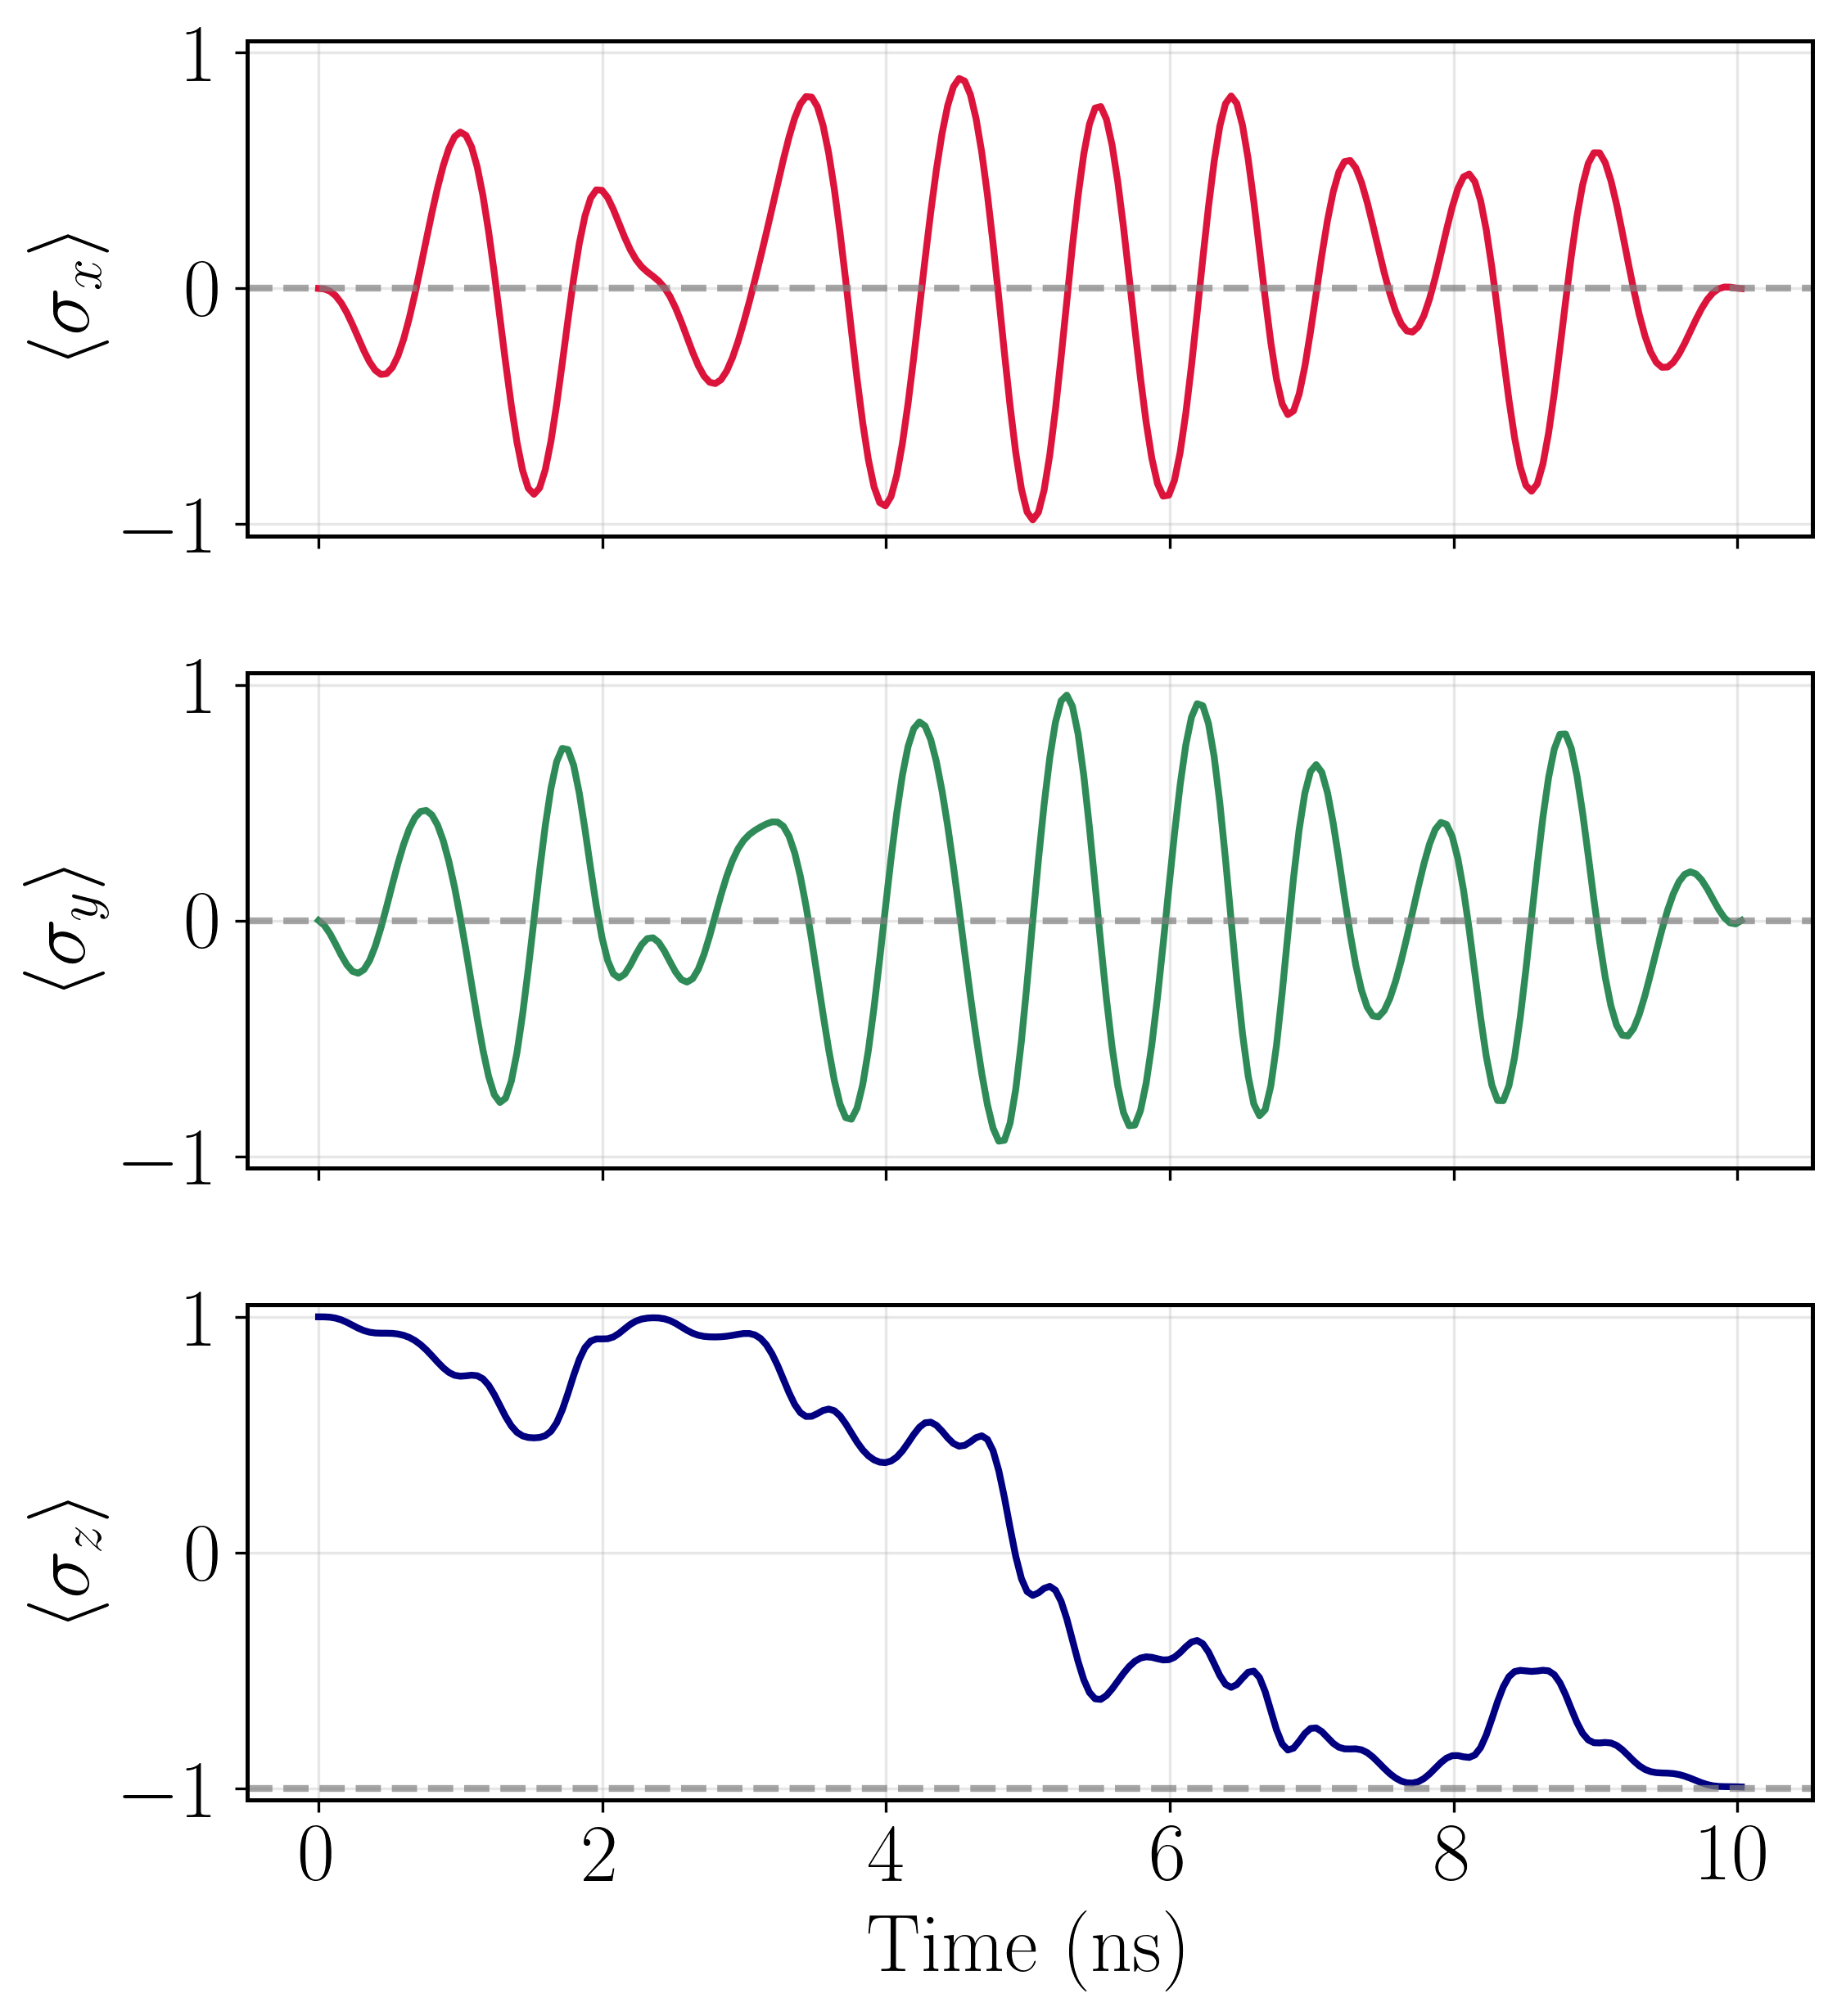

Figure saved: results/x_gate_nm_bloch_trajectory.png


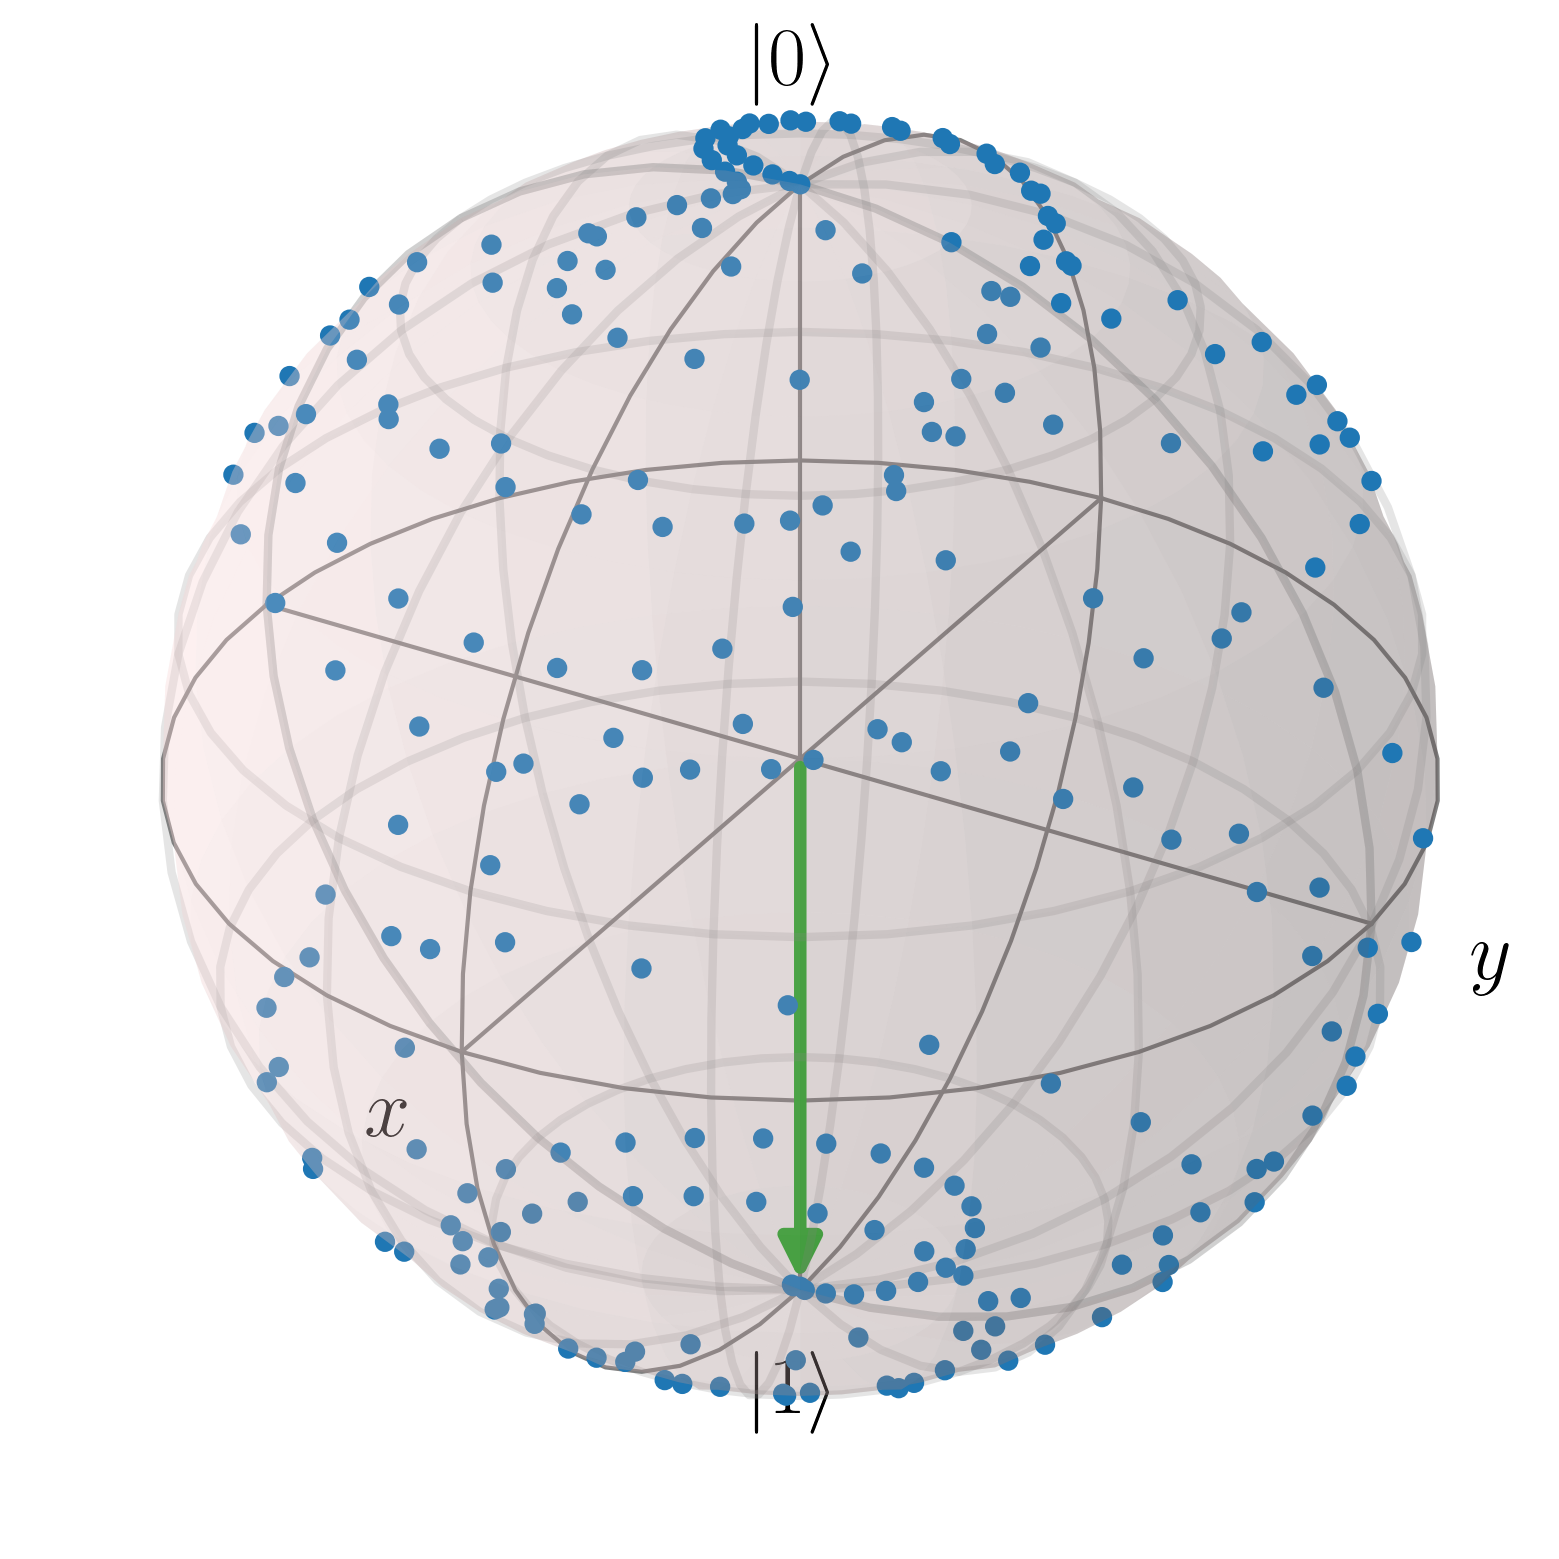

Figure saved: results/x_gate_nm_control_field_analysis.png


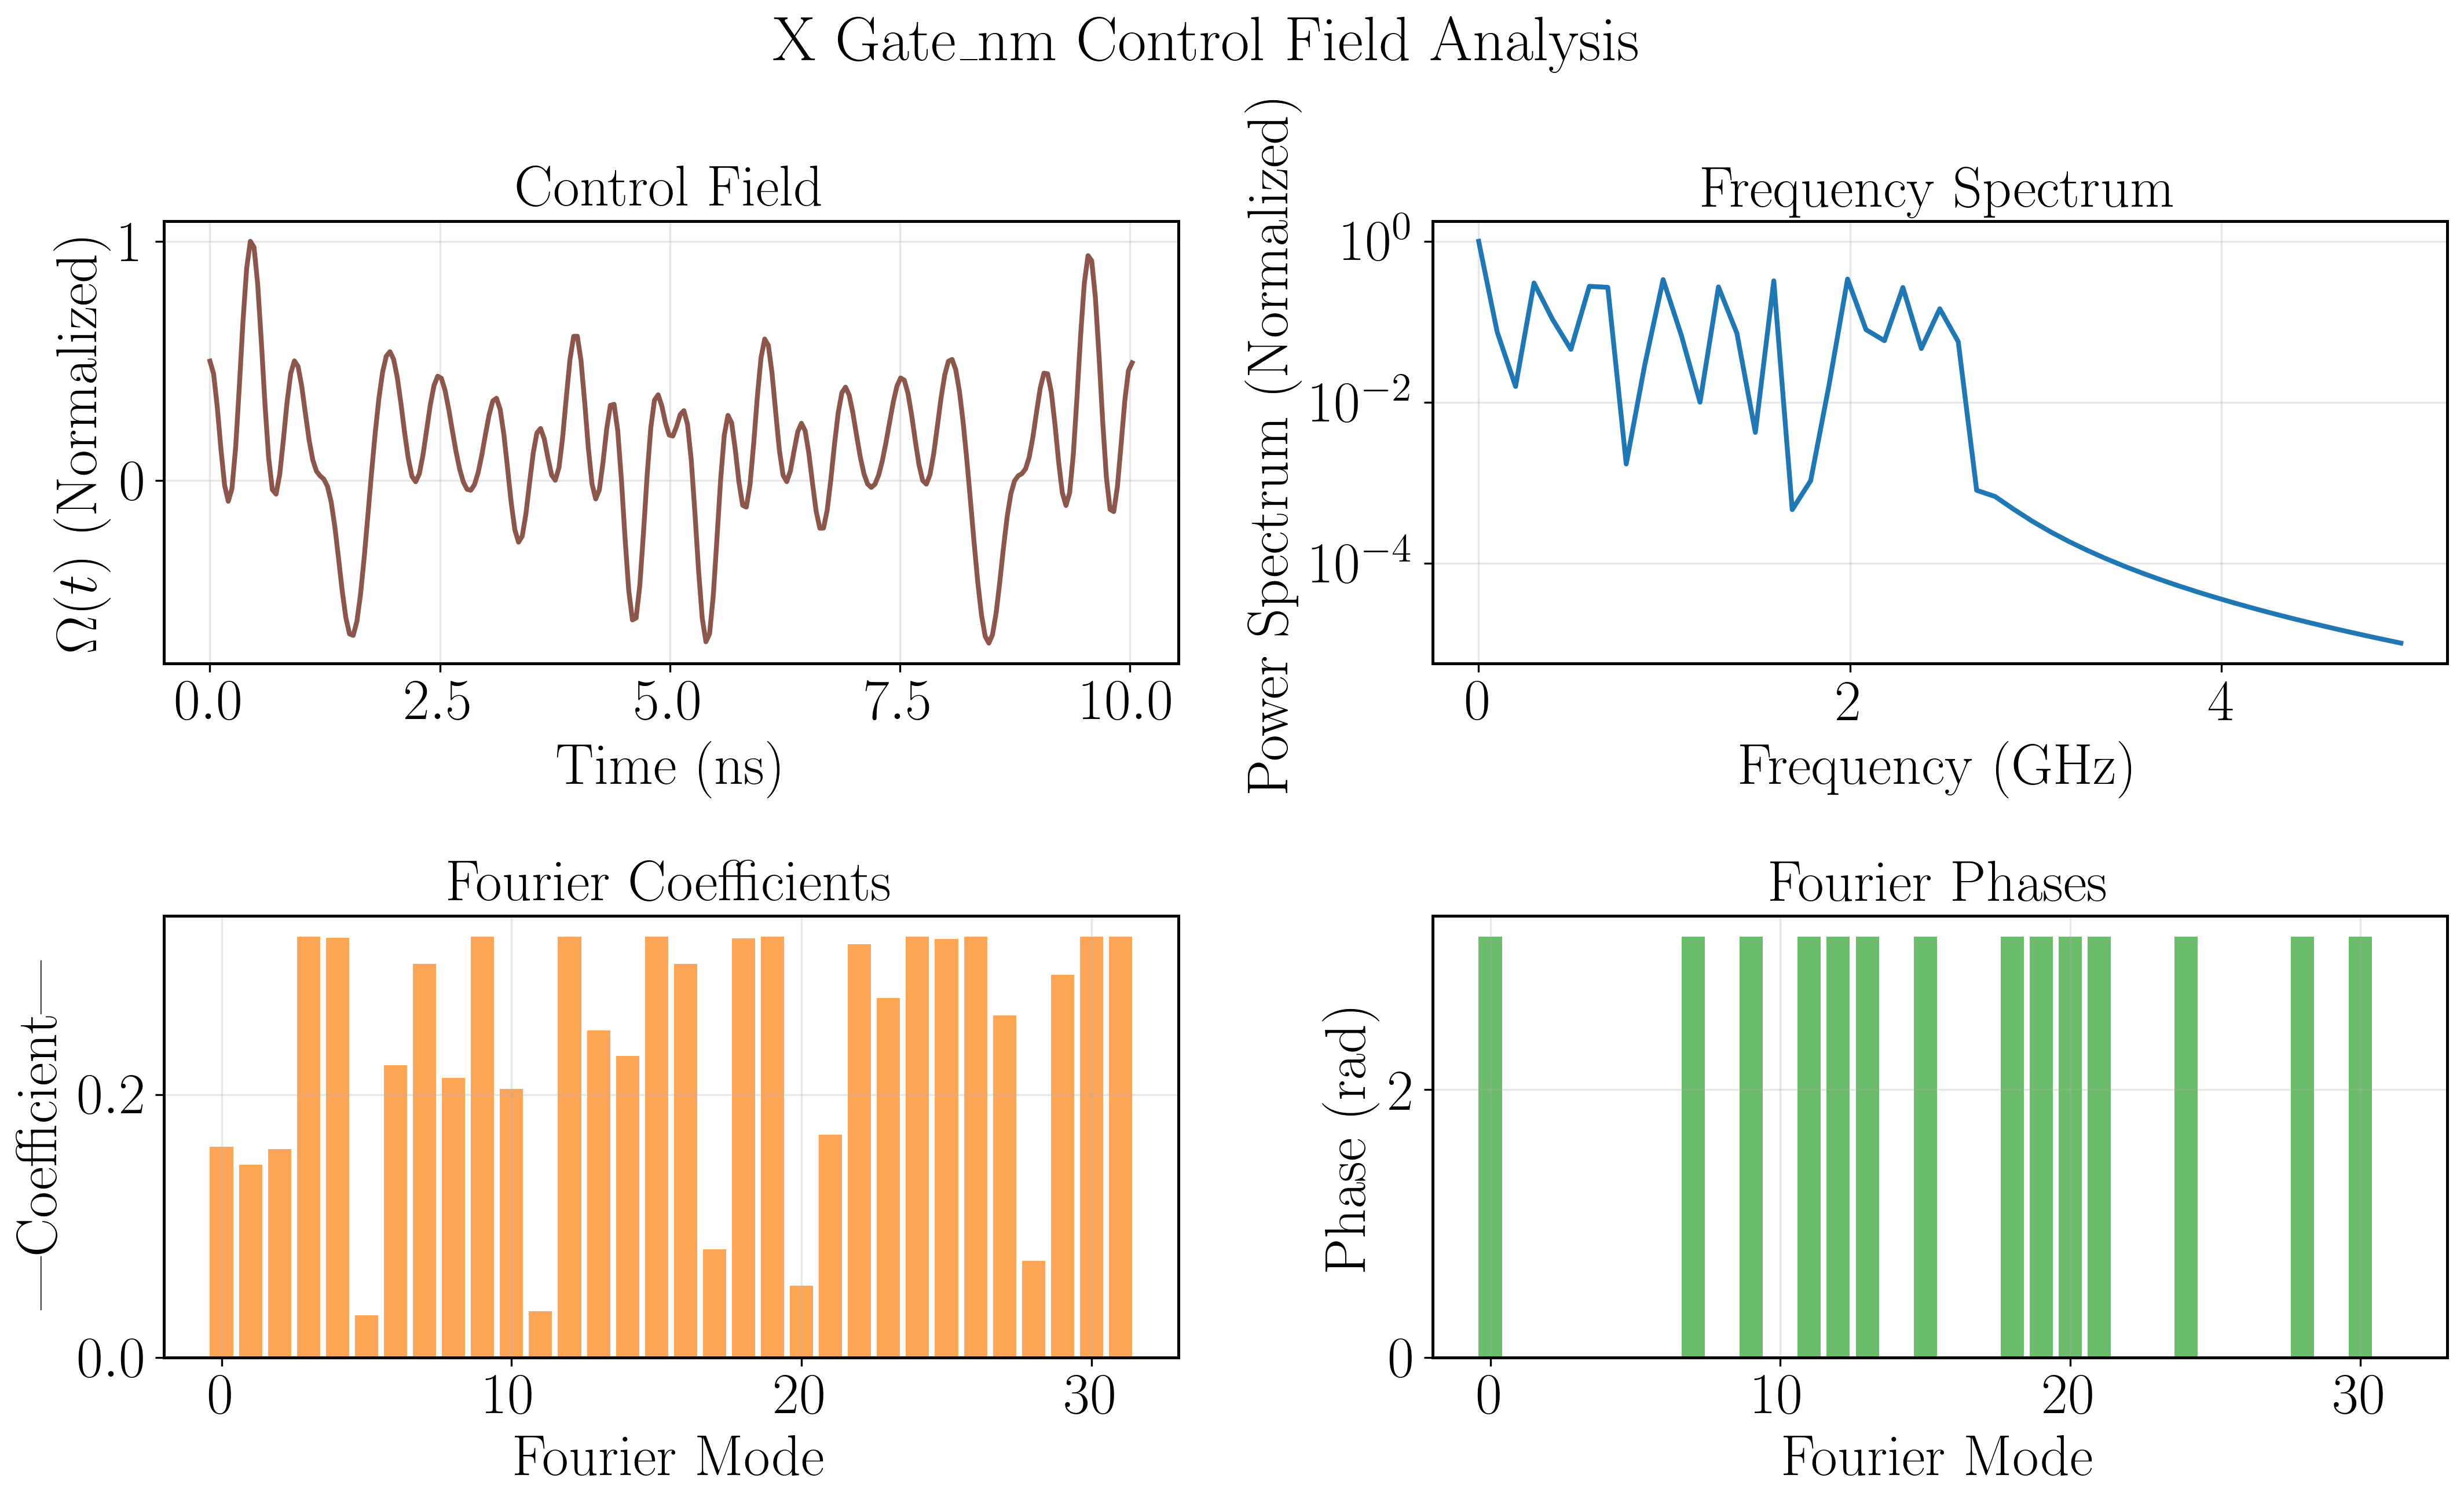

X Gate_nm final Bloch vector: [-0.00040608881784259907, -0.00029852856048929885, -0.9945695516606244]
X Gate_nm ideal Bloch vector: [0.0, 0.0, -1.0]
X Gate_nm Bloch vector error (L2): 0.0055
X Gate_nm fidelity (stored): 0.9999


In [60]:
# X Gate_nm: Refactored Plotting Using Plotting Module
x_opt_coeffs_nm = gate_results['x_gate_nm']['result']['optimization_result'].x
x_opt_period_nm = gate_results['x_gate_nm']['result']['control_period']
control_field_x_nm = compute_fourier_control_field(time_array, 
                                                   x_opt_coeffs_nm, 
                                                   x_opt_period_nm)
ex_x_nm, ey_x_nm, ez_x_nm = gate_results['x_gate_nm']['traj']
ideal_vec_x_nm = ideal_bloch['x_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_x_nm, ey_x_nm, ez_x_nm, 
                                   ideal_vector=ideal_vec_x_nm, gate_name='X Gate_nm',
                                   filename='x_gate_nm_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_x_nm, ey_x_nm, ez_x_nm, ideal_vector=ideal_vec_x_nm, gate_name='X Gate_nm',
                                    filename='x_gate_nm_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_x_nm.real, 
                                         fourier_coefficients=x_opt_coeffs_nm, title='X Gate_nm Control Field Analysis',
                                         filename='x_gate_nm_control_field_analysis.png')

final_vec_x_nm = [ex_x_nm[-1], ey_x_nm[-1], ez_x_nm[-1]]
err_x_nm = np.linalg.norm(np.array(final_vec_x_nm) - np.array(ideal_vec_x_nm))
print(f"X Gate_nm final Bloch vector: {final_vec_x_nm}")
print(f"X Gate_nm ideal Bloch vector: {ideal_vec_x_nm}")
print(f"X Gate_nm Bloch vector error (L2): {err_x_nm:.4f}")
print(f"X Gate_nm fidelity (stored): {gate_results['x_gate_nm']['fidelity']:.4f}")

In [15]:
# Run X gate optimization with Neural Network initial guess - Nelder-Mead method
start = time.time()
x_opt_res_nm_NN = optimize_x_gate(
    fourier_modes=16, max_iterations=1,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=initial_guess_x, optimization_method='Nelder-Mead'
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
x_opt_sim_nm_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_nm_NN['optimization_result'].x,
    drive_period=x_opt_res_nm_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN = extract_qubit_expectations(x_opt_sim_nm_NN['states'])

# Store
x_opt_cost_nm_NN = x_opt_res_nm_NN['optimization_result'].fun
x_opt_fid_nm_NN = 1 - x_opt_cost_nm_NN
gate_results['x_gate_nm_NN'] = {
    'result': x_opt_res_nm_NN,
    'traj': (ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN),
    'cost': x_opt_cost_nm_NN,
    'fidelity': x_opt_fid_nm_NN,
    'nfev': x_opt_res_nm_NN['nfev'],
    'time_elapsed': elapsed
}

print(f"X_nm_NN gate optimization complete: cost={x_opt_cost_nm_NN:.3e}, fidelity={x_opt_fid_nm_NN:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_nm_NN['nfev']}")

Starting optimization with provided initial guess...
Parameter space dimension: 32
Optimization method: Nelder-Mead
Variable bounds: (np.float64(-0.32), np.float64(0.32))
------------------------------------------------------------
Cost = 1.289045e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.289045e-04
Optimization success: True
Function evaluations: 1208
X_nm_NN gate optimization complete: cost=1.289e-04, fidelity=0.9999, time=150.45s
Time elapsed: 150.45 seconds
Total function evaluations: 1208


In [17]:
x_opt_res_nm_NN = np.load(f'data/payloads/x_gate/x_opt_res_nm_NN.npz', allow_pickle=True)['x_opt_res_nm_NN'].item()

# Simulate trajectory with optimal coefficients
x_opt_sim_nm_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=x_opt_res_nm_NN['optimization_result'].x,
    drive_period=x_opt_res_nm_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN = extract_qubit_expectations(x_opt_sim_nm_NN['states'])

# Store
x_opt_cost_nm_NN = x_opt_res_nm_NN['optimization_result'].fun
x_opt_fid_nm_NN = 1 - x_opt_cost_nm_NN
gate_results['x_gate_nm_NN'] = {
    'result': x_opt_res_nm_NN,
    'traj': (ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN),
    'cost': x_opt_cost_nm_NN,
    'fidelity': x_opt_fid_nm_NN,
    'nfev': x_opt_res_nm_NN['nfev'],
    'time_elapsed': 150.45 
}

print(f"X_nm_NN gate optimization complete: cost={x_opt_cost_nm_NN:.3e}, fidelity={x_opt_fid_nm_NN:.4f}, time={150.45:.2f}s")
print(f"Time elapsed: {150.45:.2f} seconds")
print(f"Total function evaluations: {x_opt_res_nm_NN['nfev']}")

X_nm_NN gate optimization complete: cost=1.289e-04, fidelity=0.9999, time=150.45s
Time elapsed: 150.45 seconds
Total function evaluations: 1208


Figure saved: results/x_gate_nm_NN_bloch_components.png


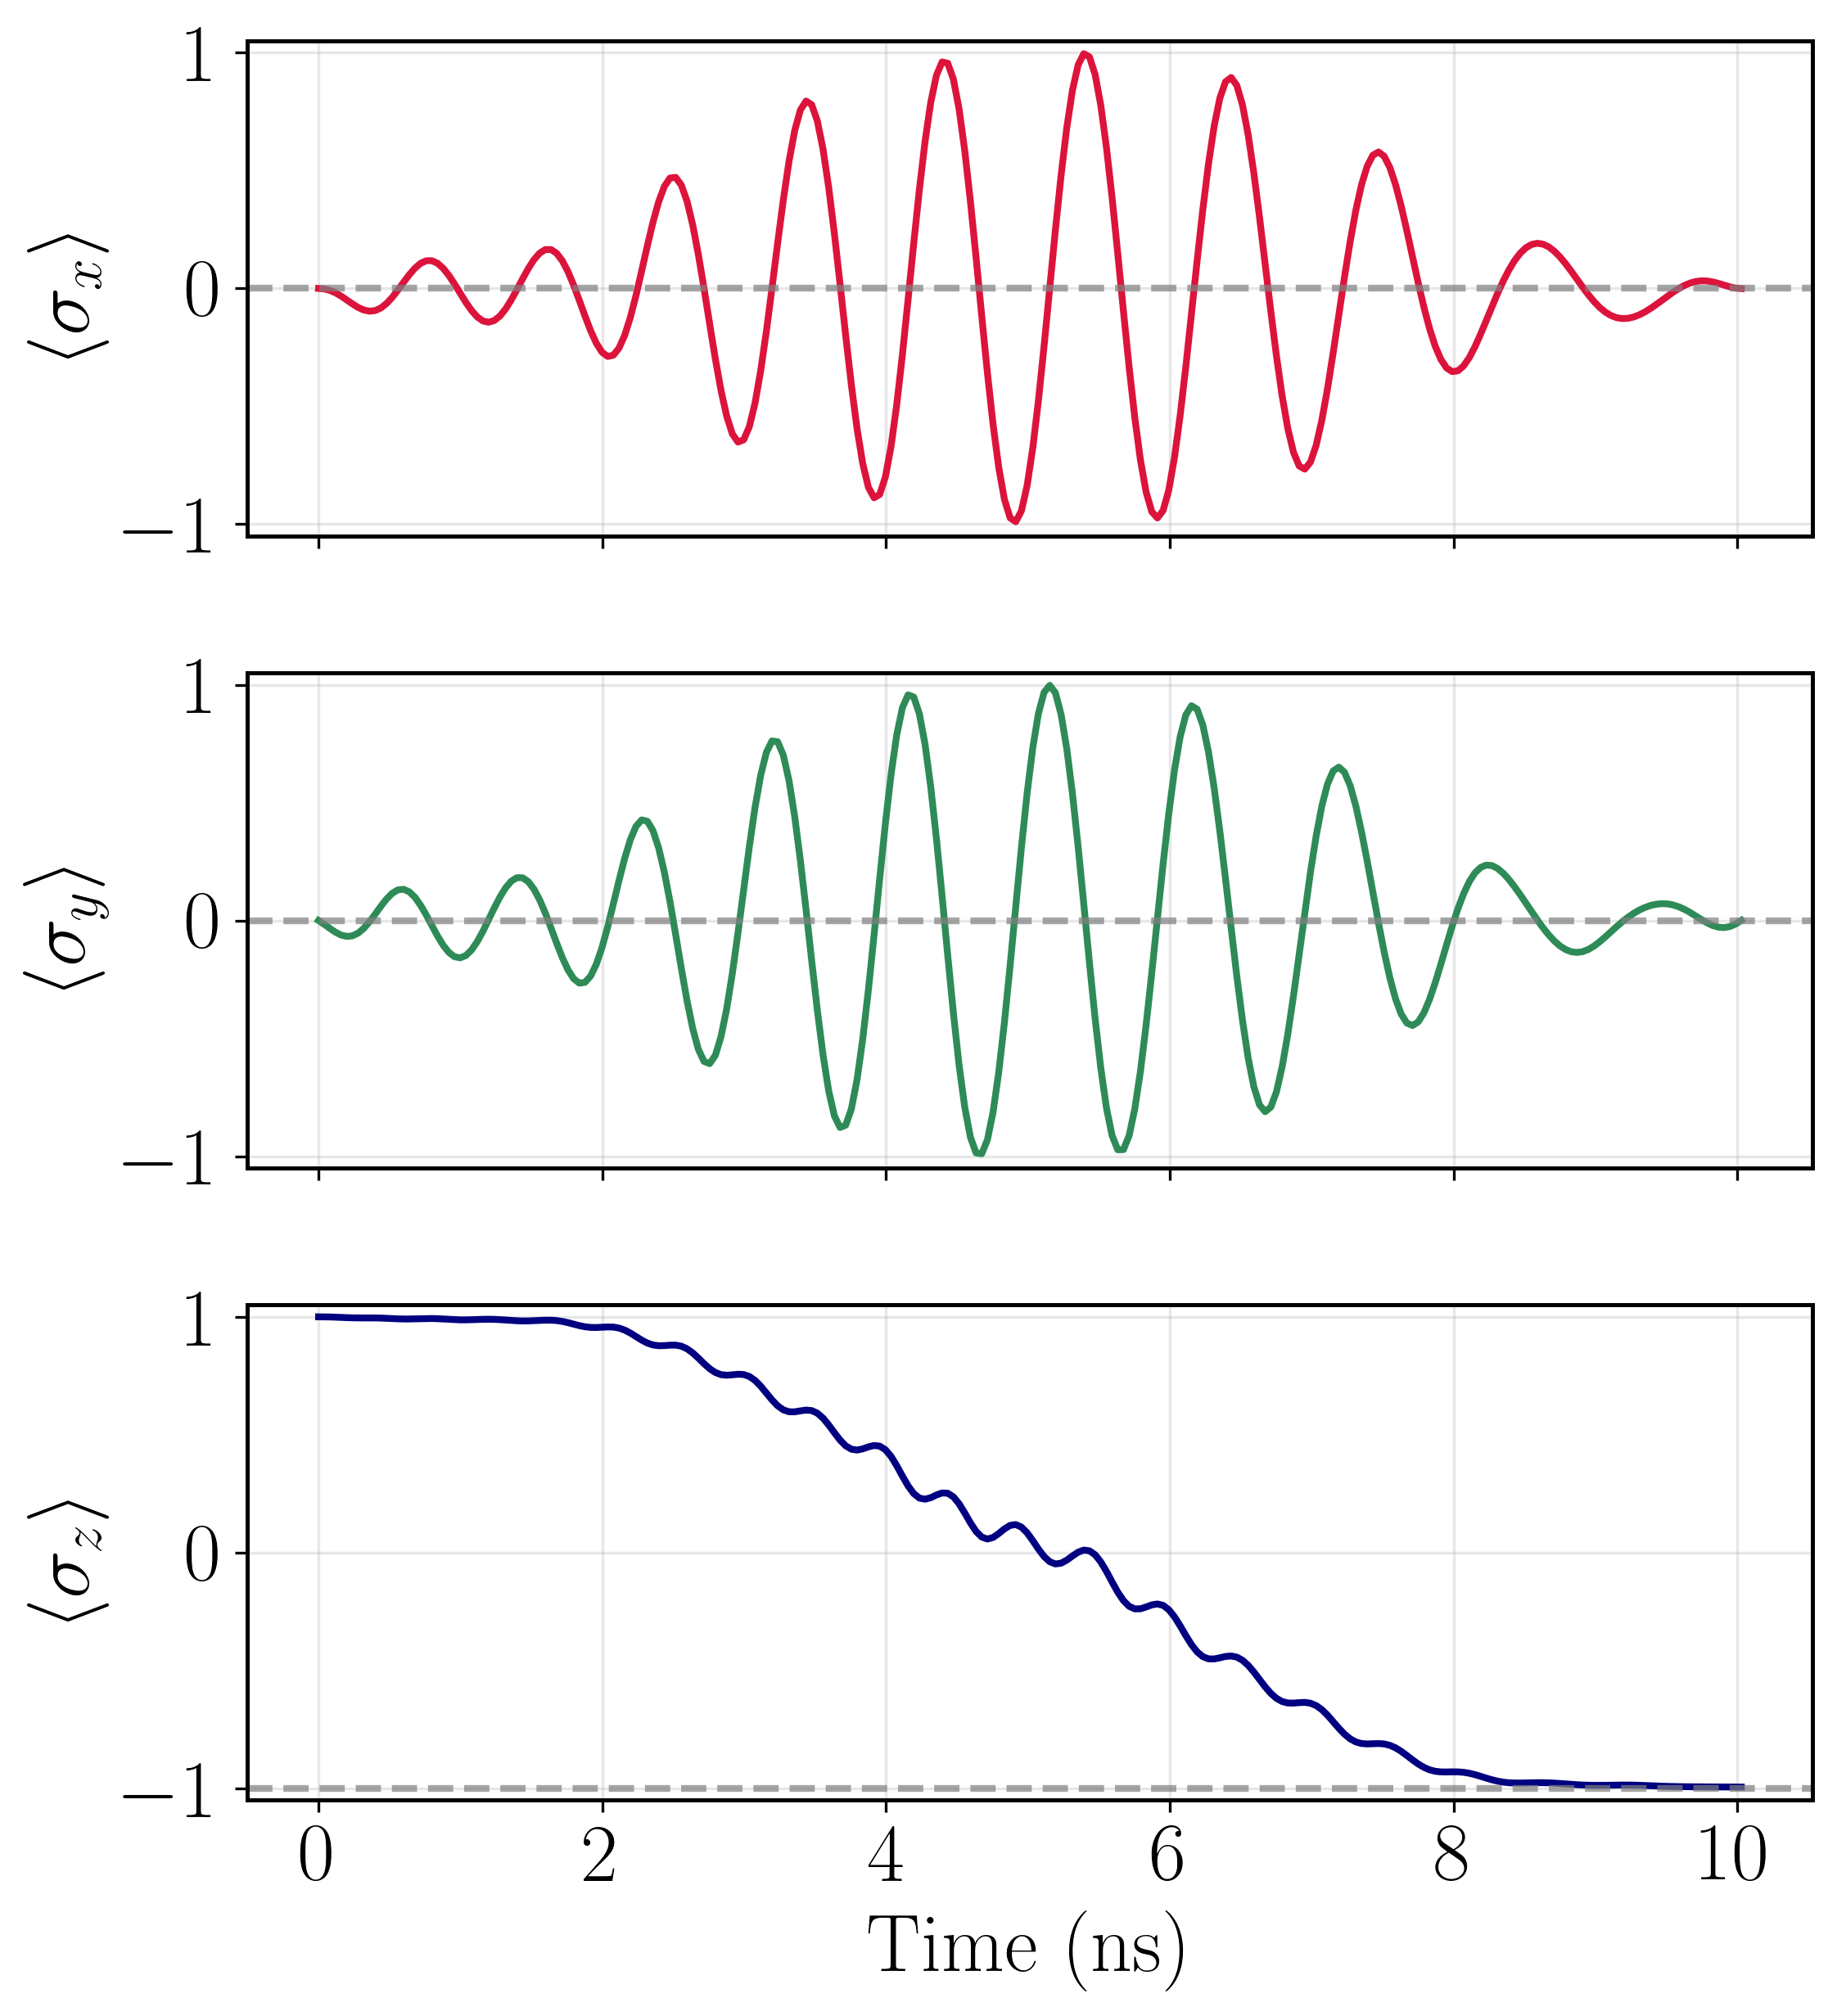

Figure saved: results/x_gate_nm_NN_bloch_trajectory.png


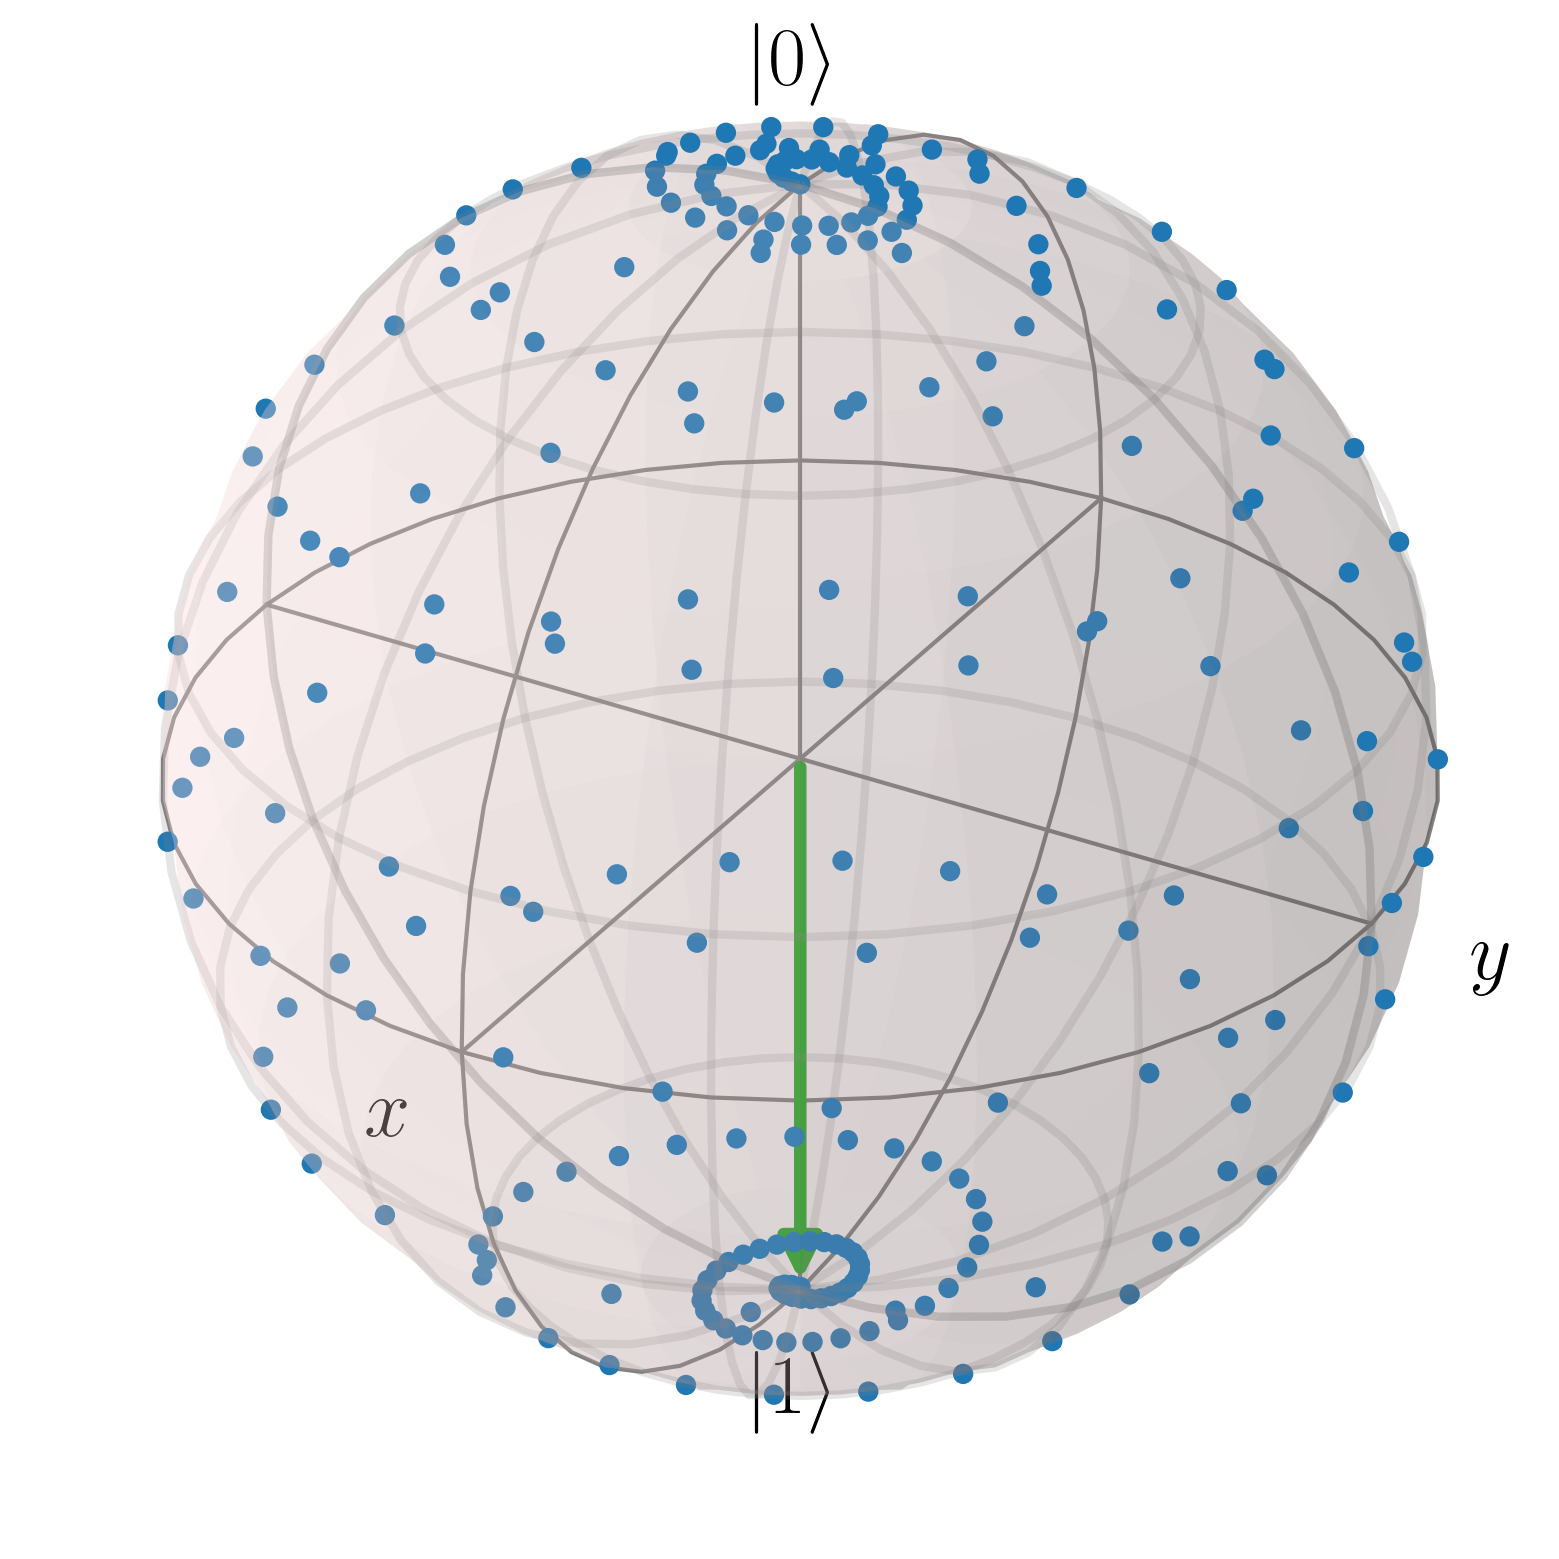

Figure saved: results/x_gate_nm_NN_control_field_analysis.png


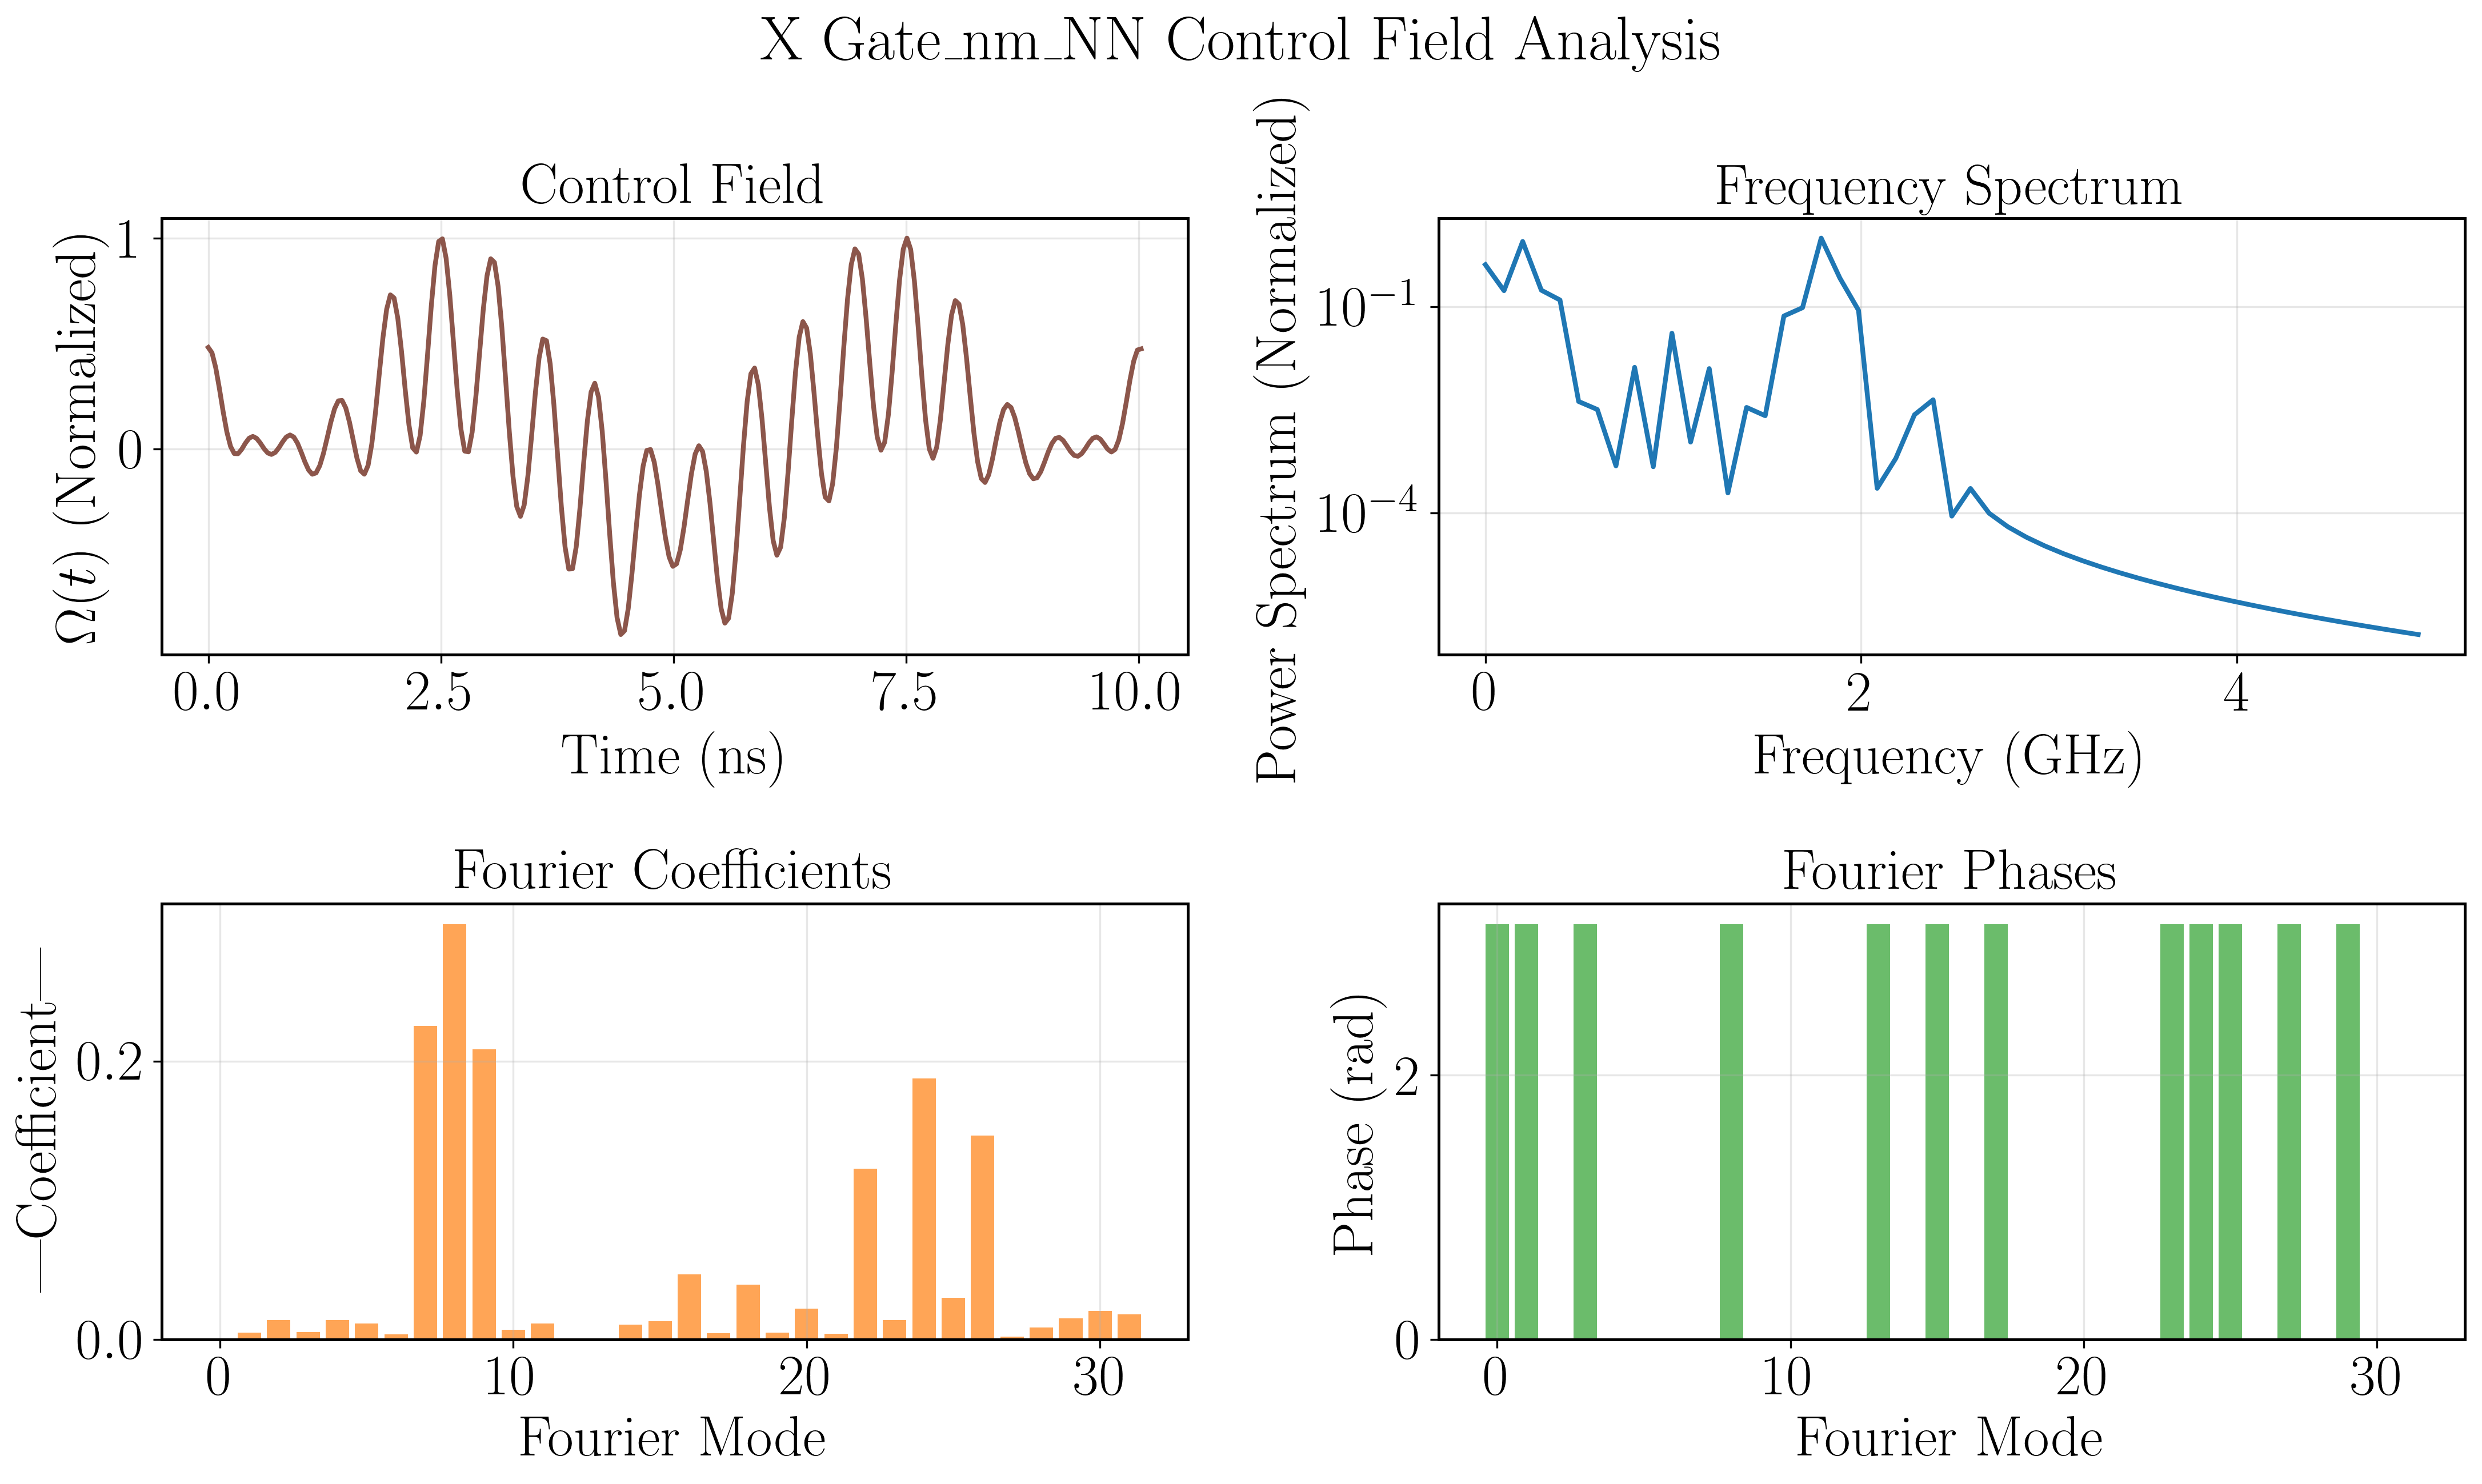

X Gate_nm_NN final Bloch vector: [-0.0006105589845798935, 0.0001805929541359234, -0.9950054559362131]
X Gate_nm_NN ideal Bloch vector: [0.0, 0.0, -1.0]
X Gate_nm_NN Bloch vector error (L2): 0.0050
X Gate_nm_NN fidelity (stored): 0.9999


In [61]:
# X Gate_nm_NN: Refactored Plotting Using Plotting Module
x_opt_coeffs_nm_NN = gate_results['x_gate_nm_NN']['result']['optimization_result'].x
x_opt_period_nm_NN = gate_results['x_gate_nm_NN']['result']['control_period']
control_field_x_nm_NN = compute_fourier_control_field(time_array, 
                                                   x_opt_coeffs_nm_NN, 
                                                   x_opt_period_nm_NN)
ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN = gate_results['x_gate_nm_NN']['traj']
ideal_vec_x_nm_NN = ideal_bloch['x_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN, 
                                   ideal_vector=ideal_vec_x_nm_NN, gate_name='X Gate_nm_NN',
                                   filename='x_gate_nm_NN_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_x_nm_NN, ey_x_nm_NN, ez_x_nm_NN, ideal_vector=ideal_vec_x_nm_NN, 
                                   gate_name='X Gate_nm_NN', filename='x_gate_nm_NN_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_x_nm_NN.real, 
                                         fourier_coefficients=x_opt_coeffs_nm_NN, title='X Gate_nm_NN Control Field Analysis',
                                         filename='x_gate_nm_NN_control_field_analysis.png')

final_vec_x_nm_NN = [ex_x_nm_NN[-1], ey_x_nm_NN[-1], ez_x_nm_NN[-1]]
err_x_nm_NN = np.linalg.norm(np.array(final_vec_x_nm_NN) - np.array(ideal_vec_x_nm_NN))
print(f"X Gate_nm_NN final Bloch vector: {final_vec_x_nm_NN}")
print(f"X Gate_nm_NN ideal Bloch vector: {ideal_vec_x_nm_NN}")
print(f"X Gate_nm_NN Bloch vector error (L2): {err_x_nm_NN:.4f}")
print(f"X Gate_nm_NN fidelity (stored): {gate_results['x_gate_nm_NN']['fidelity']:.4f}")

In [ ]:
gate_plotter = plotter

Figure saved: results/x_gate_comparison.png


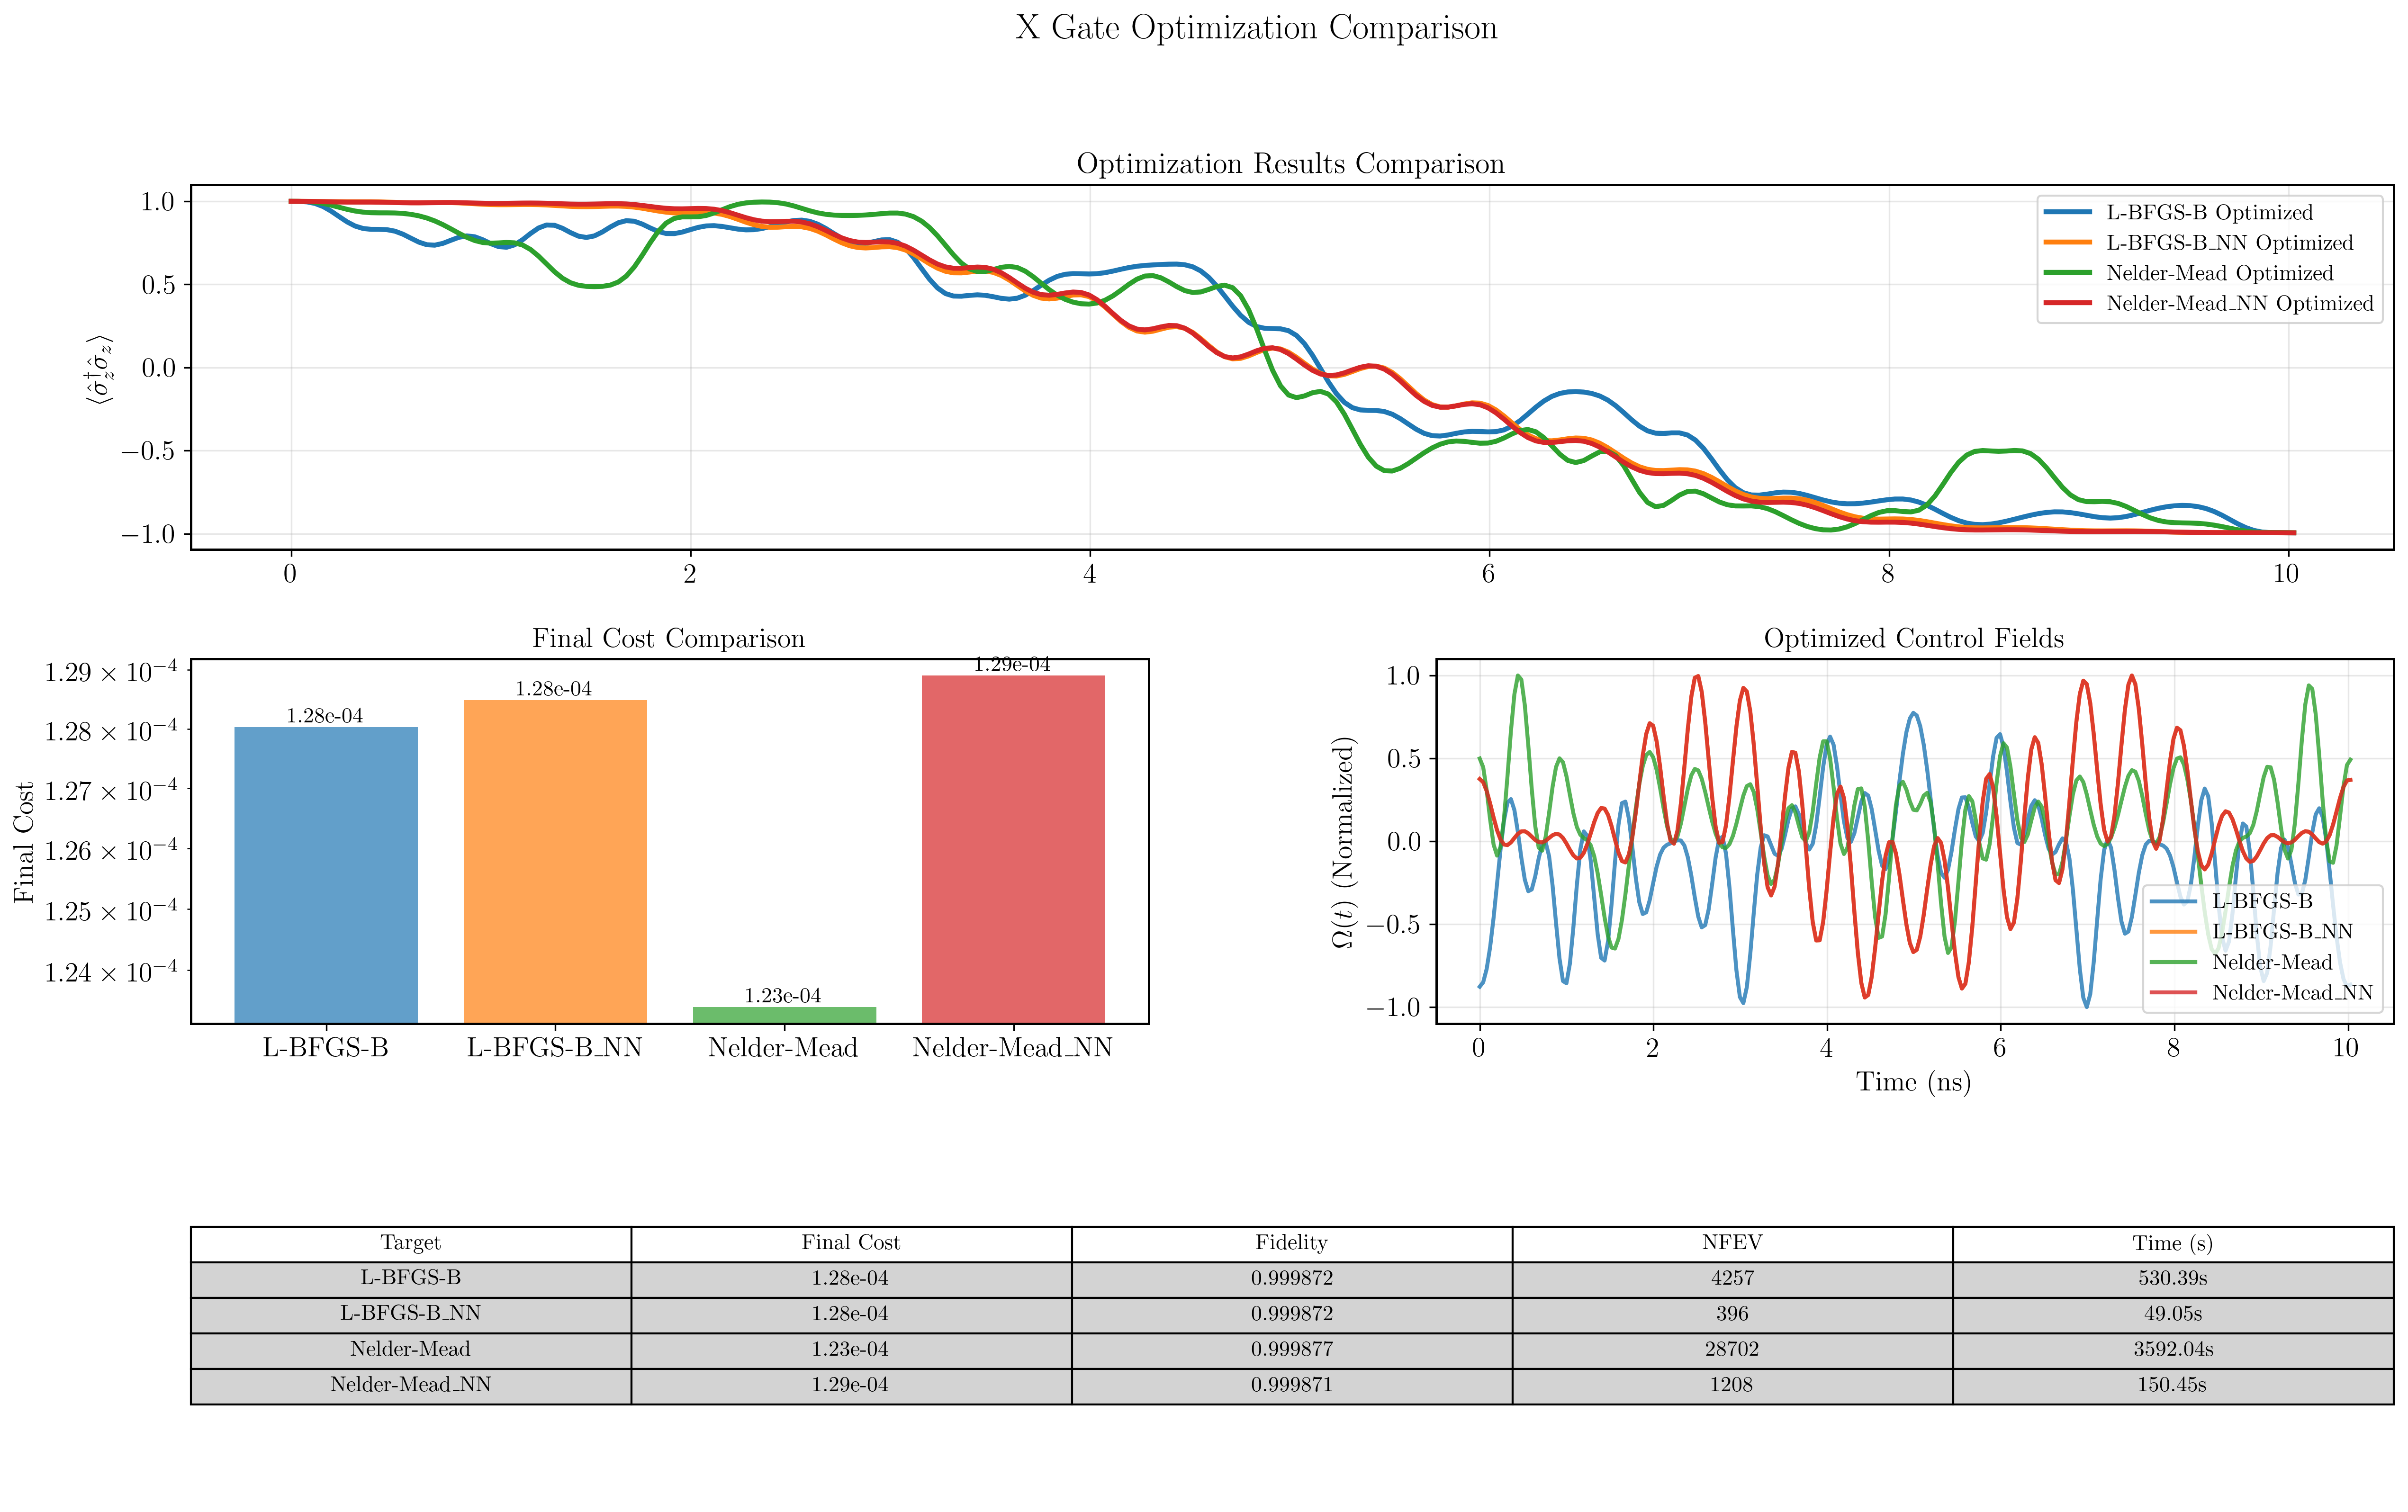

In [65]:
x_lbfgs_comparison_data = {
    'L-BFGS-B':{
        'final_cost': x_opt_cost,
        'optimized': ez_x,
        'fidelity': x_opt_fid,
        'nfev': x_opt_res['nfev'],
        'optimization_time': gate_results['x_gate']['time_elapsed'],
        'control_field': control_field_x
    },
    'L-BFGS-B_NN':{
        'final_cost': x_opt_cost_NN,
        'optimized': ez_x_NN,
        'fidelity': x_opt_fid_NN,
        'nfev': x_opt_res_NN['nfev'],
        'optimization_time': gate_results['x_gate_NN']['time_elapsed'],
        'control_field': control_field_x_NN
    },
    'Nelder-Mead':{
        'final_cost': x_opt_cost_nm,
        'optimized': ez_x_nm,
        'fidelity': x_opt_fid_nm,
        'nfev': x_opt_res_nm['nfev'],
        'optimization_time': gate_results['x_gate_nm']['time_elapsed'],
        'control_field': control_field_x_nm
    },
    'Nelder-Mead_NN':{
        'final_cost': x_opt_cost_nm_NN,
        'optimized': ez_x_nm_NN,
        'fidelity': x_opt_fid_nm_NN,
        'nfev': x_opt_res_nm_NN['nfev'],
        'optimization_time': gate_results['x_gate_nm_NN']['time_elapsed'],
        'control_field': control_field_x_NN
    }
}

gate_plotter.create_summary_figure(
    time_points=time_array,
    results_data=x_lbfgs_comparison_data,
    title='X Gate Optimization Comparison',
    filename='x_gate_comparison'
)
